In [1]:
from Feed_Forward_NN import *
#from train_fn import *
from activation_fns_and_grads import *
from loss_fns_with_regularization import *
from optimizers_with_regularization import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import wandb

In [2]:
!wandb login

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [3]:
wandb.init(project='Fashion MNIST_sweep1')

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root=''
    ,train=True
    ,download=True
    
)
test_set = torchvision.datasets.FashionMNIST(
    root=''
    ,train=False
    ,download=True
    
)

In [5]:
X_train = np.array(train_set.data)

Y_train = np.array(train_set.targets)

Y_train=Y_train.reshape(-1,1).T

X_train = X_train.reshape(X_train.shape[0],-1).T

X_train, X_val, Y_train, Y_val = train_val_split(X_train, Y_train, val_size=0.1, random_state=42)

In [6]:
# Prior to this define the model
def train(model,
      X_train = X_train,
      Y_train = Y_train,
      X_val = X_val,
      Y_val = Y_val,
      output_activation = "softmax",
      output_loss_fn = "cross_entropy",
      epochs = 50, 
      optimizer_name='adam',
      l2_lambd =0.05,
      learning_rate = 0.0002,
      lr_schedule = 0.4,
      batch_size = 512,
      print_cost = True, 
      val = True):
    
    train_costs_batches = []
    train_accuracy_batches = []
    
    train_costs=[]
    train_accuracy = []
    val_costs = []
    val_accuracy = []
    
    if optimizer_name=='sgd':
        optimizer = stochastic_gradient_descent(learning_rate=learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='momentum':
        optimizer = momentum_gradient_descent(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='rmsprop':
        optimizer = rms_prop(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='adam':
        optimizer = adam(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name== 'nesterov':
        optimizer = nesterov_gradient_descent(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='nadam':
        optimizer = nadam(params = model.params, learning_rate= learning_rate, beta1=0.9, beta2=0.999 , l2_lambd=l2_lambd)
        
    if batch_size==None:
        batch_size = X_train.shape[1]
        
    for i in range(1,epochs+1):
        if i%10==0:
            optimizer.lr=optimizer.lr * lr_schedule
        '''decay = 0.001
        optimizer.lr=optimizer.lr * 1/(1 + decay * i)'''
        
        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        no_batches = len(mini_batches)
        
        epoch_loss=0
        epoch_correct=0
        
        
        for j , mini_batch in enumerate(mini_batches,1):
            X_mini, Y_mini = mini_batch
            bs = X_mini.shape[1]
            if bs==0:
                break
            
            # Forward Propagation
            XL = model.forward_prop(X_mini) ## final layer output w/o activation
            Y_pred = act_fn(XL,output_activation)
            
            # Compute cost
            batch_cost = cost_fn(model.params,Y_mini,Y_pred, l2_lambd=l2_lambd, output_activation=output_activation, loss_fn=output_loss_fn)
            batch_correct = np.sum(onehot_to_class(Y_pred)==Y_mini)
            
            epoch_loss += batch_cost*bs
            epoch_correct += batch_correct
            
            # Backward propagation
            ## look forward step
            if optimizer_name=='nesterov' or optimizer_name=='nadam':
                optimizer.update_params_prior_grad(model)
            
            dZ=output_exc_act_grad(Y_mini,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)

            model.backward_prop(dZ)

            # Update parameters.
            if optimizer_name== 'nesterov' or optimizer_name=='nadam':
                optimizer.update_params_after_grad(model)
            else:
                optimizer.update_params(model)

            # Print the cost every 100 training batch
            if j % 100 == 0:
                train_costs_batches.append(batch_cost)
                train_accuracy_batches.append(batch_correct/Y_mini.shape[1])
        
        epoch_loss = epoch_loss / X_train.shape[1]
        epoch_correct = epoch_correct / X_train.shape[1]
        
        train_costs.append(epoch_loss)
        train_accuracy.append(epoch_correct)
        wandb.log({'epoch': i,'train loss': epoch_loss,'train accuracy': epoch_correct})
        if val :
            val_acc,val_loss=accuracy_loss(model,X_val,Y_val,output_activation=output_activation,output_loss_fn=output_loss_fn)
            val_costs.append(val_loss)
            val_accuracy.append(val_acc)
            
            wandb.log({'val loss': val_loss,'val accuracy': val_acc})
            if print_cost:
                print("val cost for epoch ", i , "= ",val_loss)
                print("val accuracy for epoch ", i , "= ",val_acc)
                print("train cost for epoch ", i , "= ",epoch_loss)
                print("train accuracy for epoch ", i , "= ",epoch_correct)
                print("")
            
    # plot the cost per 100 batches
    plt.plot(np.squeeze(train_costs_batches))
    plt.plot(np.squeeze(train_accuracy_batches))
    plt.ylabel('train_costs_batches')
    plt.xlabel('batches (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    


In [7]:
def layers_config_str(s):
    l=list(map(int, s.split('-')))
    return l

In [8]:
def sp_train():
    config_defaults = {
        'epochs': 5,
        'hidden_layers_config':'32' ,
        'L2_regularization': 0.0005,
        'dropout':0.8,
        'learning_rate': 1e-4,
        'optimizer': 'adam',
        'batch_size': 128,
        'weight_initialization': 'xavier' ,
        'activation_fns': 'relu'
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    run_name="ep:["+str(config.epochs)+"] hl:["+config.hidden_layers_config+"] lr:["+str(config.learning_rate)+"] op:["+config.optimizer+"] bs:["+str(config.batch_size)+"] ac:["+config.activation_fns+"] L2:["+str(config.L2_regularization)+"] dp:["+str(config.dropout)+"]"
    wandb.run.name=run_name
    #wandb.init(config=config_defaults, name= run_name)
    
    
    
    nn=FeedForward_NN(input_features= 784, 
                  output_nodes=10, 
                  hidden_layers_dims=layers_config_str(config.hidden_layers_config),
                  act_fn=config.activation_fns,
                  dropout = config.dropout,
                  initialization=config.weight_initialization)
    
    train(model=nn,
          X_train = X_train,
          Y_train = Y_train,
          X_val = X_val,
          Y_val = Y_val,
          output_activation = "softmax",
          output_loss_fn = "cross_entropy",
          epochs = config.epochs, 
          optimizer_name= config.optimizer,
          l2_lambd = config.L2_regularization,
          learning_rate = config.learning_rate,
          lr_schedule = 1,
          batch_size = config.batch_size,
          print_cost = True, 
          val = True)

In [9]:
sweep_config = {
    'method': 'grid', 
    'metric': {
      'name': 'val accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values':[5]
        },
        'hidden_layers_config': {
            'values': ['32',
                       '64',
                       '128',
                       '256',
                       '32-64',
                       '64-32', 
                       '64-32-32',
                       '128-128'
                       ]
        },
        'L2_regularization': {
            'values':[0.0005, 0.05] 
        },
        'dropout':{
            'values':[0.8]
        },
        'learning_rate':{
            'values': [1e-4,1e-3]
        },
        'optimizer': {
            'values':['adam','nadam']
        },
        'batch_size': {
            'values':[128]
        },
        'weight_initialization': {
            'values':['xavier'] 
        },
        'activation_fns': {
            'values':['relu']
        }
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_config, project="Sweep_1")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: xob6u9z0
Sweep URL: https://wandb.ai/rayanz/Sweep_1/sweeps/xob6u9z0


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: evcbtcj9 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5814221847075542
val accuracy for epoch  1 =  0.7826666666666666
train cost for epoch  1 =  0.7681726841262125
train accuracy for epoch  1 =  0.7282037037037037

val cost for epoch  2 =  0.48944929153062877
val accuracy for epoch  2 =  0.8255
train cost for epoch  2 =  0.5103643729993225
train accuracy for epoch  2 =  0.8223703703703704

val cost for epoch  3 =  0.46208149360364315
val accuracy for epoch  3 =  0.8348333333333333
train cost for epoch  3 =  0.464849369120676
train accuracy for epoch  3 =  0.8357962962962963

val cost for epoch  4 =  0.44417057172261254
val accuracy for epoch  4 =  0.8396666666666667
train cost for epoch  4 =  0.44037708598861713
train accuracy for epoch  4 =  0.8446481481481481

val cost for epoch  5 =  0.4403513118331495
val accuracy for epoch  5 =  0.8388333333333333
train cost for epoch  5 =  0.42436348162695436
train accuracy for epoch  5 =  0.849037037037037



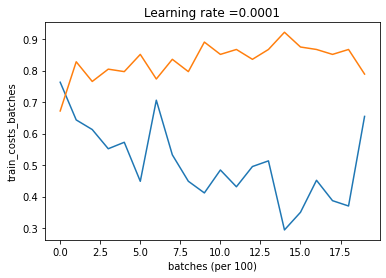

epoch,5
train loss,0.42436
train accuracy,0.84904
_runtime,13
_timestamp,1615556395
_step,9
val loss,0.44035
val accuracy,0.83883


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▂▁▁
val accuracy,▁▆▇██


wandb: Agent Starting Run: nvg7mymy with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7429310157458664
val accuracy for epoch  1 =  0.732
train cost for epoch  1 =  1.0459460837044219
train accuracy for epoch  1 =  0.6474444444444445

val cost for epoch  2 =  0.6185371961894617
val accuracy for epoch  2 =  0.7758333333333334
train cost for epoch  2 =  0.6601410503829636
train accuracy for epoch  2 =  0.7682407407407408

val cost for epoch  3 =  0.5769264664996161
val accuracy for epoch  3 =  0.789
train cost for epoch  3 =  0.5819337614688844
train accuracy for epoch  3 =  0.798537037037037

val cost for epoch  4 =  0.5379334151341729
val accuracy for epoch  4 =  0.812
train cost for epoch  4 =  0.5412662249480555
train accuracy for epoch  4 =  0.8131111111111111

val cost for epoch  5 =  0.5137806587729149
val accuracy for epoch  5 =  0.8223333333333334
train cost for epoch  5 =  0.5134347582267211
train accuracy for epoch  5 =  0.8237037037037037



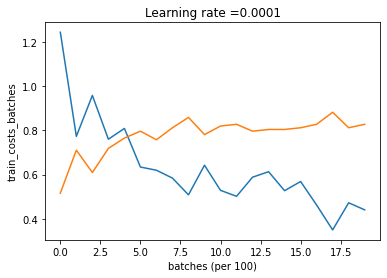

epoch,5
train loss,0.51343
train accuracy,0.8237
_runtime,14
_timestamp,1615556414
_step,9
val loss,0.51378
val accuracy,0.82233


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▂▃▅▅▆▇▇█
_timestamp,▁▂▂▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▄▅▇█


wandb: Agent Starting Run: dls1wlls with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5975802084555807
val accuracy for epoch  1 =  0.7811666666666667
train cost for epoch  1 =  0.6834705625121132
train accuracy for epoch  1 =  0.7510740740740741

val cost for epoch  2 =  0.5462480226279718
val accuracy for epoch  2 =  0.8018333333333333
train cost for epoch  2 =  0.560746963931374
train accuracy for epoch  2 =  0.7982222222222223

val cost for epoch  3 =  0.5475048925286579
val accuracy for epoch  3 =  0.7975
train cost for epoch  3 =  0.5423936829189298
train accuracy for epoch  3 =  0.8074074074074075

val cost for epoch  4 =  0.5401172090049978
val accuracy for epoch  4 =  0.8093333333333333
train cost for epoch  4 =  0.527169006415162
train accuracy for epoch  4 =  0.8108888888888889

val cost for epoch  5 =  0.5813876346099468
val accuracy for epoch  5 =  0.786
train cost for epoch  5 =  0.5097976038441864
train accuracy for epoch  5 =  0.8170185185185185



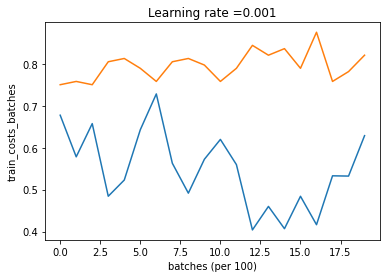

epoch,5
train loss,0.5098
train accuracy,0.81702
_runtime,15
_timestamp,1615556434
_step,9
val loss,0.58139
val accuracy,0.786


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇▇█
_runtime,▁▂▃▄▅▅▆▇▇█
_timestamp,▁▂▃▄▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▂▂▁▆
val accuracy,▁▆▅█▂


wandb: Agent Starting Run: xjk4uq9s with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5511687829831751
val accuracy for epoch  1 =  0.7976666666666666
train cost for epoch  1 =  0.6583953130805508
train accuracy for epoch  1 =  0.7618518518518519

val cost for epoch  2 =  0.48355222198039294
val accuracy for epoch  2 =  0.8253333333333334
train cost for epoch  2 =  0.4901579429299286
train accuracy for epoch  2 =  0.8261851851851851

val cost for epoch  3 =  0.4744767554059723
val accuracy for epoch  3 =  0.8248333333333333
train cost for epoch  3 =  0.4608032215742223
train accuracy for epoch  3 =  0.8343148148148148

val cost for epoch  4 =  0.4662825412369753
val accuracy for epoch  4 =  0.8293333333333334
train cost for epoch  4 =  0.4404411688900749
train accuracy for epoch  4 =  0.8416481481481481

val cost for epoch  5 =  0.4420773326933878
val accuracy for epoch  5 =  0.8435
train cost for epoch  5 =  0.42754524435080665
train accuracy for epoch  5 =  0.8478703703703704



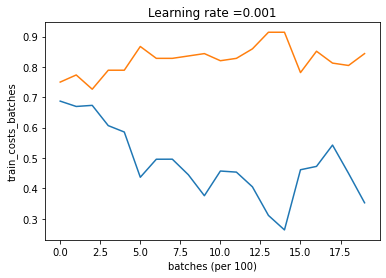

epoch,5
train loss,0.42755
train accuracy,0.84787
_runtime,15
_timestamp,1615556454
_step,9
val loss,0.44208
val accuracy,0.8435


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇▇█
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▃▁
val accuracy,▁▅▅▆█


wandb: Agent Starting Run: 82u8ayz9 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5453934434235339
val accuracy for epoch  1 =  0.8105
train cost for epoch  1 =  0.6939127962436965
train accuracy for epoch  1 =  0.7598888888888888

val cost for epoch  2 =  0.456207807239249
val accuracy for epoch  2 =  0.8361666666666666
train cost for epoch  2 =  0.4721851728509546
train accuracy for epoch  2 =  0.8355370370370371

val cost for epoch  3 =  0.435650668644236
val accuracy for epoch  3 =  0.8435
train cost for epoch  3 =  0.42607259582922064
train accuracy for epoch  3 =  0.8499629629629629

val cost for epoch  4 =  0.40523515445515884
val accuracy for epoch  4 =  0.8551666666666666
train cost for epoch  4 =  0.40047001608074756
train accuracy for epoch  4 =  0.8584814814814815

val cost for epoch  5 =  0.40729563497167276
val accuracy for epoch  5 =  0.8535
train cost for epoch  5 =  0.3839157062246435
train accuracy for epoch  5 =  0.8638148148148148



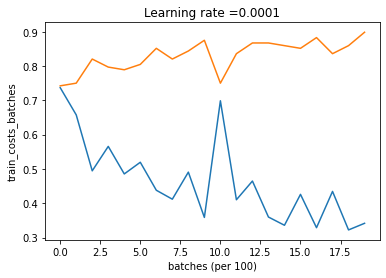

epoch,5
train loss,0.38392
train accuracy,0.86381
_runtime,16
_timestamp,1615556474
_step,9
val loss,0.4073
val accuracy,0.8535


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▁▁
val accuracy,▁▅▆██


wandb: Agent Starting Run: xbh9ceqe with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6584150649320889
val accuracy for epoch  1 =  0.7671666666666667
train cost for epoch  1 =  0.9512206534797901
train accuracy for epoch  1 =  0.6823888888888889

val cost for epoch  2 =  0.5674501402769574
val accuracy for epoch  2 =  0.8008333333333333
train cost for epoch  2 =  0.5930840211210553
train accuracy for epoch  2 =  0.7969259259259259

val cost for epoch  3 =  0.5200229920187117
val accuracy for epoch  3 =  0.8181666666666667
train cost for epoch  3 =  0.5271813743241438
train accuracy for epoch  3 =  0.8222777777777778

val cost for epoch  4 =  0.4821703723823651
val accuracy for epoch  4 =  0.831
train cost for epoch  4 =  0.48895035302154116
train accuracy for epoch  4 =  0.834462962962963

val cost for epoch  5 =  0.47320230966001015
val accuracy for epoch  5 =  0.8303333333333334
train cost for epoch  5 =  0.4654571054444073
train accuracy for epoch  5 =  0.8422222222222222



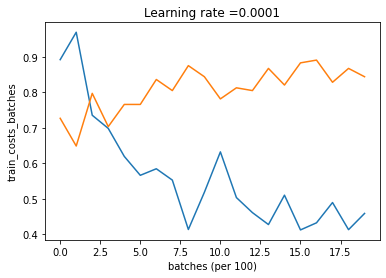

epoch,5
train loss,0.46546
train accuracy,0.84222
_runtime,17
_timestamp,1615556497
_step,9
val loss,0.4732
val accuracy,0.83033


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▁▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: 6q2fg8p5 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5833137546982282
val accuracy for epoch  1 =  0.7885
train cost for epoch  1 =  0.6498549145358103
train accuracy for epoch  1 =  0.7621851851851852

val cost for epoch  2 =  0.5497710167298453
val accuracy for epoch  2 =  0.802
train cost for epoch  2 =  0.5739829866599245
train accuracy for epoch  2 =  0.7939074074074074

val cost for epoch  3 =  0.598121712558606
val accuracy for epoch  3 =  0.7825
train cost for epoch  3 =  0.5326855970626947
train accuracy for epoch  3 =  0.8107222222222222

val cost for epoch  4 =  0.550666769933653
val accuracy for epoch  4 =  0.8133333333333334
train cost for epoch  4 =  0.5014553936464764
train accuracy for epoch  4 =  0.8220555555555555

val cost for epoch  5 =  0.5101316115568089
val accuracy for epoch  5 =  0.8248333333333333
train cost for epoch  5 =  0.4998766366256714
train accuracy for epoch  5 =  0.8230740740740741



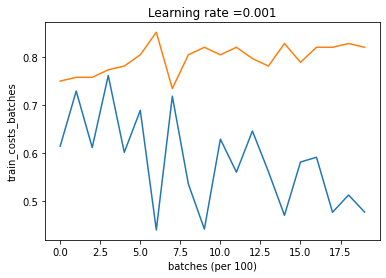

epoch,5
train loss,0.49988
train accuracy,0.82307
_runtime,18
_timestamp,1615556519
_step,9
val loss,0.51013
val accuracy,0.82483


epoch,▁▃▅▆█
train loss,█▄▃▁▁
train accuracy,▁▅▇██
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,▇▄█▄▁
val accuracy,▂▄▁▆█


wandb: Agent Starting Run: 5172mrhj with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5127958367411055
val accuracy for epoch  1 =  0.8096666666666666
train cost for epoch  1 =  0.6027266981032832
train accuracy for epoch  1 =  0.7830555555555555

val cost for epoch  2 =  0.45134902894717244
val accuracy for epoch  2 =  0.835
train cost for epoch  2 =  0.44416463193941896
train accuracy for epoch  2 =  0.8411111111111111

val cost for epoch  3 =  0.44458518434036465
val accuracy for epoch  3 =  0.8451666666666666
train cost for epoch  3 =  0.4107776530032582
train accuracy for epoch  3 =  0.8532962962962963

val cost for epoch  4 =  0.41022864006517473
val accuracy for epoch  4 =  0.8468333333333333
train cost for epoch  4 =  0.3880482106431324
train accuracy for epoch  4 =  0.8619629629629629

val cost for epoch  5 =  0.4030543153212777
val accuracy for epoch  5 =  0.854
train cost for epoch  5 =  0.369923111861769
train accuracy for epoch  5 =  0.8662037037037037



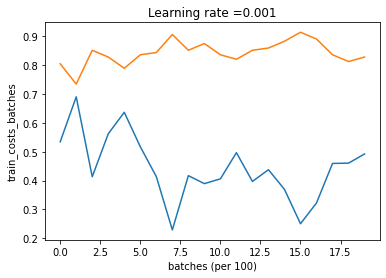

epoch,5
train loss,0.36992
train accuracy,0.8662
_runtime,18
_timestamp,1615556542
_step,9
val loss,0.40305
val accuracy,0.854


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▄▁▁
val accuracy,▁▅▇▇█


wandb: Agent Starting Run: vwuil482 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.45274152818818336
val accuracy for epoch  1 =  0.8376666666666667
train cost for epoch  1 =  0.6176000996645225
train accuracy for epoch  1 =  0.7864629629629629

val cost for epoch  2 =  0.4191296791020322
val accuracy for epoch  2 =  0.8516666666666667
train cost for epoch  2 =  0.428497166669749
train accuracy for epoch  2 =  0.8489814814814814

val cost for epoch  3 =  0.4224741521389653
val accuracy for epoch  3 =  0.847
train cost for epoch  3 =  0.38603864487107825
train accuracy for epoch  3 =  0.8622777777777778

val cost for epoch  4 =  0.37843530067893155
val accuracy for epoch  4 =  0.8641666666666666
train cost for epoch  4 =  0.361817552800187
train accuracy for epoch  4 =  0.8707592592592592

val cost for epoch  5 =  0.37183306552083367
val accuracy for epoch  5 =  0.865
train cost for epoch  5 =  0.34515027964439254
train accuracy for epoch  5 =  0.8773703703703704



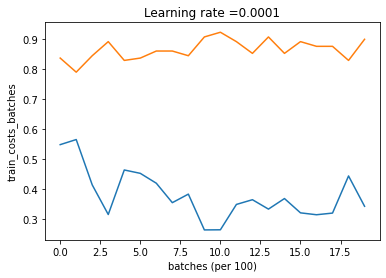

epoch,5
train loss,0.34515
train accuracy,0.87737
_runtime,26
_timestamp,1615556573
_step,9
val loss,0.37183
val accuracy,0.865


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇▇█
_runtime,▁▁▃▃▅▅▆▇██
_timestamp,▁▁▃▃▅▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▅▂▁
val accuracy,▁▅▃██


wandb: Agent Starting Run: hsmx2tcl with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6168141712149264
val accuracy for epoch  1 =  0.7823333333333333
train cost for epoch  1 =  0.8696386193210387
train accuracy for epoch  1 =  0.7027592592592593

val cost for epoch  2 =  0.5317237909205789
val accuracy for epoch  2 =  0.8171666666666667
train cost for epoch  2 =  0.5478201788159098
train accuracy for epoch  2 =  0.8114444444444444

val cost for epoch  3 =  0.48708653182974526
val accuracy for epoch  3 =  0.828
train cost for epoch  3 =  0.4883449008579852
train accuracy for epoch  3 =  0.8342777777777778

val cost for epoch  4 =  0.4483778015611605
val accuracy for epoch  4 =  0.8453333333333334
train cost for epoch  4 =  0.45487056444368784
train accuracy for epoch  4 =  0.8447222222222223

val cost for epoch  5 =  0.4336481353277674
val accuracy for epoch  5 =  0.851
train cost for epoch  5 =  0.43265581436076084
train accuracy for epoch  5 =  0.851037037037037



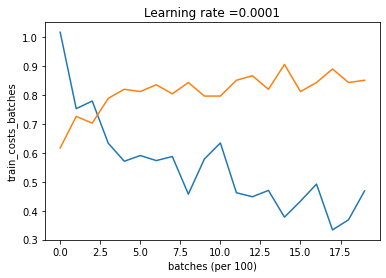

epoch,5
train loss,0.43266
train accuracy,0.85104
_runtime,23
_timestamp,1615556601
_step,9
val loss,0.43365
val accuracy,0.851


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▅▆▇█


wandb: Agent Starting Run: 929bvj8d with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5269252591843454
val accuracy for epoch  1 =  0.801
train cost for epoch  1 =  0.6300179608584552
train accuracy for epoch  1 =  0.7732407407407408

val cost for epoch  2 =  0.5880786670587254
val accuracy for epoch  2 =  0.8001666666666667
train cost for epoch  2 =  0.5669836935653253
train accuracy for epoch  2 =  0.7983333333333333

val cost for epoch  3 =  0.5337937497635405
val accuracy for epoch  3 =  0.8061666666666667
train cost for epoch  3 =  0.5299321584621831
train accuracy for epoch  3 =  0.8100740740740741

val cost for epoch  4 =  0.5451432816432846
val accuracy for epoch  4 =  0.8001666666666667
train cost for epoch  4 =  0.5039350429208975
train accuracy for epoch  4 =  0.8194259259259259

val cost for epoch  5 =  0.5293536668646716
val accuracy for epoch  5 =  0.8095
train cost for epoch  5 =  0.5009903349602155
train accuracy for epoch  5 =  0.8192407407407407



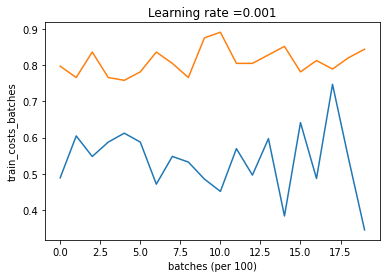

epoch,5
train loss,0.50099
train accuracy,0.81924
_runtime,21
_timestamp,1615556629
_step,9
val loss,0.52935
val accuracy,0.8095


epoch,▁▃▅▆█
train loss,█▅▃▁▁
train accuracy,▁▅▇██
_runtime,▁▁▂▃▄▅▆▆██
_timestamp,▁▁▂▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,▁█▂▃▁
val accuracy,▂▁▅▁█


wandb: Agent Starting Run: 3rfg9jij with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.48559890989673
val accuracy for epoch  1 =  0.8216666666666667
train cost for epoch  1 =  0.5785857131066937
train accuracy for epoch  1 =  0.7901296296296296

val cost for epoch  2 =  0.4161375730032183
val accuracy for epoch  2 =  0.8508333333333333
train cost for epoch  2 =  0.4241443169651783
train accuracy for epoch  2 =  0.8487222222222223

val cost for epoch  3 =  0.4142698801962544
val accuracy for epoch  3 =  0.8465
train cost for epoch  3 =  0.38530074326318053
train accuracy for epoch  3 =  0.8627592592592592

val cost for epoch  4 =  0.3808642951766947
val accuracy for epoch  4 =  0.8655
train cost for epoch  4 =  0.3640097456686192
train accuracy for epoch  4 =  0.8676296296296296

val cost for epoch  5 =  0.3840873023829739
val accuracy for epoch  5 =  0.8626666666666667
train cost for epoch  5 =  0.3468616195353261
train accuracy for epoch  5 =  0.8737222222222222



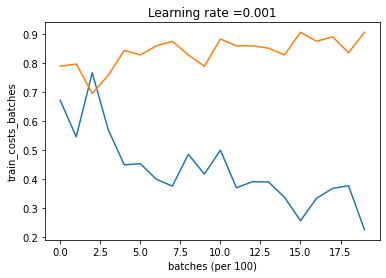

epoch,5
train loss,0.34686
train accuracy,0.87372
_runtime,24
_timestamp,1615556657
_step,9
val loss,0.38409
val accuracy,0.86267


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇▇█
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▃▁▁
val accuracy,▁▆▅██


wandb: Agent Starting Run: sisczgqh with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4450221797250757
val accuracy for epoch  1 =  0.8371666666666666
train cost for epoch  1 =  0.5918204298196619
train accuracy for epoch  1 =  0.790037037037037

val cost for epoch  2 =  0.4119151741655158
val accuracy for epoch  2 =  0.8543333333333333
train cost for epoch  2 =  0.41103733337391773
train accuracy for epoch  2 =  0.8546111111111111

val cost for epoch  3 =  0.39270623088005085
val accuracy for epoch  3 =  0.8598333333333333
train cost for epoch  3 =  0.3722764685536496
train accuracy for epoch  3 =  0.8670555555555556

val cost for epoch  4 =  0.3580074170513759
val accuracy for epoch  4 =  0.8686666666666667
train cost for epoch  4 =  0.3449978401108632
train accuracy for epoch  4 =  0.8759444444444444

val cost for epoch  5 =  0.35949333423596863
val accuracy for epoch  5 =  0.8728333333333333
train cost for epoch  5 =  0.3286100941762452
train accuracy for epoch  5 =  0.8818148148148148



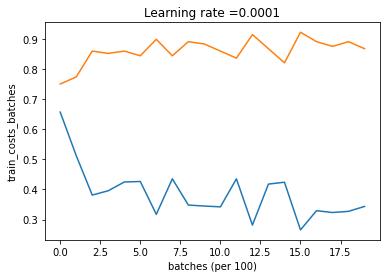

epoch,5
train loss,0.32861
train accuracy,0.88181
_runtime,68
_timestamp,1615556732
_step,9
val loss,0.35949
val accuracy,0.87283


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▄▁▁
val accuracy,▁▄▅▇█


wandb: Agent Starting Run: b70bdh39 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5861681554816414
val accuracy for epoch  1 =  0.7846666666666666
train cost for epoch  1 =  0.7949812591961464
train accuracy for epoch  1 =  0.7365555555555555

val cost for epoch  2 =  0.4956653997201776
val accuracy for epoch  2 =  0.8236666666666667
train cost for epoch  2 =  0.5095648195984874
train accuracy for epoch  2 =  0.8244259259259259

val cost for epoch  3 =  0.45487553870571296
val accuracy for epoch  3 =  0.8368333333333333
train cost for epoch  3 =  0.4574018930441922
train accuracy for epoch  3 =  0.8427407407407408

val cost for epoch  4 =  0.4277349562436359
val accuracy for epoch  4 =  0.8485
train cost for epoch  4 =  0.42624612136349826
train accuracy for epoch  4 =  0.8534444444444444

val cost for epoch  5 =  0.41281862852708173
val accuracy for epoch  5 =  0.8521666666666666
train cost for epoch  5 =  0.4040072631001398
train accuracy for epoch  5 =  0.8621481481481481



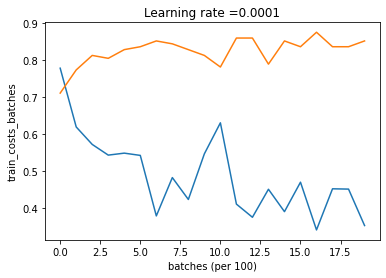

epoch,5
train loss,0.40401
train accuracy,0.86215
_runtime,82
_timestamp,1615556821
_step,9
val loss,0.41282
val accuracy,0.85217


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▆██


wandb: Agent Starting Run: lhb5pwud with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.615089410002006
val accuracy for epoch  1 =  0.7715
train cost for epoch  1 =  0.6452486820619416
train accuracy for epoch  1 =  0.7693518518518518

val cost for epoch  2 =  0.5278929966159984
val accuracy for epoch  2 =  0.8106666666666666
train cost for epoch  2 =  0.572950230092815
train accuracy for epoch  2 =  0.7983888888888889

val cost for epoch  3 =  0.5160082727233929
val accuracy for epoch  3 =  0.809
train cost for epoch  3 =  0.5209375734798798
train accuracy for epoch  3 =  0.8160185185185185

val cost for epoch  4 =  0.5414195161134808
val accuracy for epoch  4 =  0.805
train cost for epoch  4 =  0.5051194467616188
train accuracy for epoch  4 =  0.8221296296296297

val cost for epoch  5 =  0.5203375543163302
val accuracy for epoch  5 =  0.8198333333333333
train cost for epoch  5 =  0.48300898657728286
train accuracy for epoch  5 =  0.8291111111111111



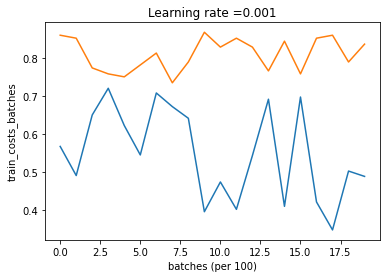

epoch,5
train loss,0.48301
train accuracy,0.82911
_runtime,61
_timestamp,1615556889
_step,9
val loss,0.52034
val accuracy,0.81983


epoch,▁▃▅▆█
train loss,█▅▃▂▁
train accuracy,▁▄▆▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▂▁▃▁
val accuracy,▁▇▆▆█


wandb: Agent Starting Run: sh0r4tf3 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4417833046474727
val accuracy for epoch  1 =  0.8376666666666667
train cost for epoch  1 =  0.5770605154350901
train accuracy for epoch  1 =  0.7894814814814815

val cost for epoch  2 =  0.4083046697409319
val accuracy for epoch  2 =  0.8516666666666667
train cost for epoch  2 =  0.4168537374964521
train accuracy for epoch  2 =  0.8498148148148148

val cost for epoch  3 =  0.38689174874285814
val accuracy for epoch  3 =  0.8583333333333333
train cost for epoch  3 =  0.3758362944199171
train accuracy for epoch  3 =  0.8643333333333333

val cost for epoch  4 =  0.3782965486391897
val accuracy for epoch  4 =  0.8626666666666667
train cost for epoch  4 =  0.3549969142713495
train accuracy for epoch  4 =  0.8710740740740741

val cost for epoch  5 =  0.41053397981262235
val accuracy for epoch  5 =  0.8493333333333334
train cost for epoch  5 =  0.33561006929223475
train accuracy for epoch  5 =  0.8786111111111111



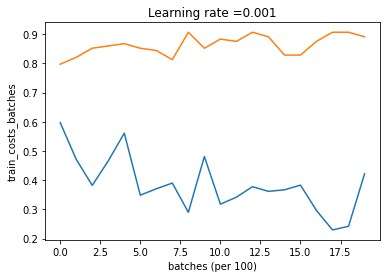

epoch,5
train loss,0.33561
train accuracy,0.87861
_runtime,77
_timestamp,1615556971
_step,9
val loss,0.41053
val accuracy,0.84933


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇▇█
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▁▅
val accuracy,▁▅▇█▄


wandb: Agent Starting Run: 7sshhu59 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.8853616075325359
val accuracy for epoch  1 =  0.6383333333333333
train cost for epoch  1 =  1.1912388342700346
train accuracy for epoch  1 =  0.5229444444444444

val cost for epoch  2 =  0.7322581484874596
val accuracy for epoch  2 =  0.7216666666666667
train cost for epoch  2 =  0.7949679450407978
train accuracy for epoch  2 =  0.6966296296296296

val cost for epoch  3 =  0.6659364894785921
val accuracy for epoch  3 =  0.7495
train cost for epoch  3 =  0.6913978001642533
train accuracy for epoch  3 =  0.7497962962962963

val cost for epoch  4 =  0.6291098520504764
val accuracy for epoch  4 =  0.769
train cost for epoch  4 =  0.6361218427119663
train accuracy for epoch  4 =  0.7721481481481481

val cost for epoch  5 =  0.5932161098710865
val accuracy for epoch  5 =  0.7915
train cost for epoch  5 =  0.6043266026192716
train accuracy for epoch  5 =  0.7907592592592593



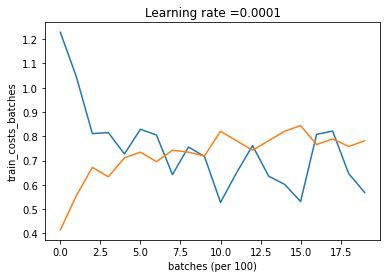

epoch,5
train loss,0.60433
train accuracy,0.79076
_runtime,16
_timestamp,1615556994
_step,9
val loss,0.59322
val accuracy,0.7915


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▆▇█


wandb: Agent Starting Run: z6dioup8 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.3237250591673158
val accuracy for epoch  1 =  0.4145
train cost for epoch  1 =  1.697819000986859
train accuracy for epoch  1 =  0.30348148148148146

val cost for epoch  2 =  1.1567109507587405
val accuracy for epoch  2 =  0.5108333333333334
train cost for epoch  2 =  1.225761966363349
train accuracy for epoch  2 =  0.4719074074074074

val cost for epoch  3 =  1.0498328790451252
val accuracy for epoch  3 =  0.5698333333333333
train cost for epoch  3 =  1.10319965186813
train accuracy for epoch  3 =  0.5503518518518519

val cost for epoch  4 =  0.9812872718802728
val accuracy for epoch  4 =  0.6028333333333333
train cost for epoch  4 =  1.0174004613752
train accuracy for epoch  4 =  0.5945185185185186

val cost for epoch  5 =  0.952124709637879
val accuracy for epoch  5 =  0.6235
train cost for epoch  5 =  0.9648645542259747
train accuracy for epoch  5 =  0.6175555555555555



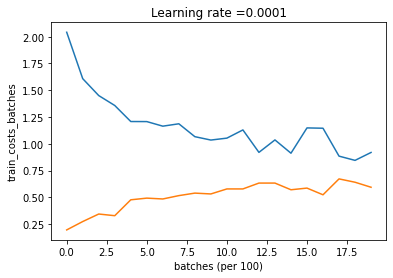

epoch,5
train loss,0.96486
train accuracy,0.61756
_runtime,17
_timestamp,1615557015
_step,9
val loss,0.95212
val accuracy,0.6235


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▅▇▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: rl4ptpxx with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6406834921070654
val accuracy for epoch  1 =  0.7636666666666667
train cost for epoch  1 =  0.8070879605218544
train accuracy for epoch  1 =  0.692925925925926

val cost for epoch  2 =  0.590522488975091
val accuracy for epoch  2 =  0.7805
train cost for epoch  2 =  0.5806422872769521
train accuracy for epoch  2 =  0.790037037037037

val cost for epoch  3 =  0.5408423418970257
val accuracy for epoch  3 =  0.8028333333333333
train cost for epoch  3 =  0.5342010795542538
train accuracy for epoch  3 =  0.8067222222222222

val cost for epoch  4 =  0.5094726739936128
val accuracy for epoch  4 =  0.8151666666666667
train cost for epoch  4 =  0.515416653473682
train accuracy for epoch  4 =  0.812962962962963

val cost for epoch  5 =  0.5055790106779956
val accuracy for epoch  5 =  0.8201666666666667
train cost for epoch  5 =  0.4991221305445363
train accuracy for epoch  5 =  0.8199814814814815



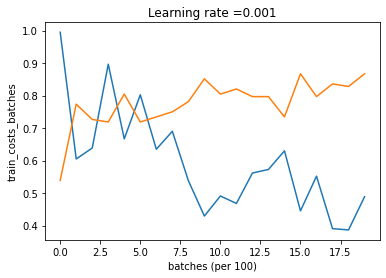

epoch,5
train loss,0.49912
train accuracy,0.81998
_runtime,17
_timestamp,1615557038
_step,9
val loss,0.50558
val accuracy,0.82017


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▁▁
val accuracy,▁▃▆▇█


wandb: Agent Starting Run: gxo359o9 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7915217019402535
val accuracy for epoch  1 =  0.7063333333333334
train cost for epoch  1 =  1.0303721897657778
train accuracy for epoch  1 =  0.5823148148148148

val cost for epoch  2 =  0.6180731563264791
val accuracy for epoch  2 =  0.7798333333333334
train cost for epoch  2 =  0.6715427150104306
train accuracy for epoch  2 =  0.7600185185185185

val cost for epoch  3 =  0.5620339789555259
val accuracy for epoch  3 =  0.7983333333333333
train cost for epoch  3 =  0.5798015149766956
train accuracy for epoch  3 =  0.7978518518518518

val cost for epoch  4 =  0.5263606592605893
val accuracy for epoch  4 =  0.8066666666666666
train cost for epoch  4 =  0.5370007283945435
train accuracy for epoch  4 =  0.8127777777777778

val cost for epoch  5 =  0.5358820316117432
val accuracy for epoch  5 =  0.8111666666666667
train cost for epoch  5 =  0.5108577012654373
train accuracy for epoch  5 =  0.8223703703703704



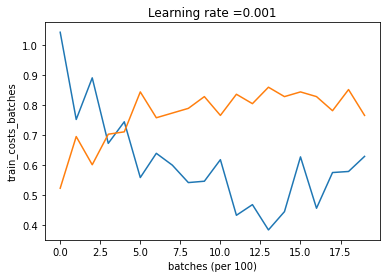

epoch,5
train loss,0.51086
train accuracy,0.82237
_runtime,16
_timestamp,1615557058
_step,9
val loss,0.53588
val accuracy,0.81117


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▂▁▁
val accuracy,▁▆▇██


wandb: Agent Starting Run: 4zy4vg9g with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.8454775075755142
val accuracy for epoch  1 =  0.6658333333333334
train cost for epoch  1 =  1.1894268500049687
train accuracy for epoch  1 =  0.5183703703703704

val cost for epoch  2 =  0.6863197492053674
val accuracy for epoch  2 =  0.7416666666666667
train cost for epoch  2 =  0.7511066315909893
train accuracy for epoch  2 =  0.7207592592592592

val cost for epoch  3 =  0.608766878957991
val accuracy for epoch  3 =  0.7838333333333334
train cost for epoch  3 =  0.6338466293432438
train accuracy for epoch  3 =  0.7761481481481481

val cost for epoch  4 =  0.5742371361545543
val accuracy for epoch  4 =  0.7951666666666667
train cost for epoch  4 =  0.5762442229121124
train accuracy for epoch  4 =  0.7998888888888889

val cost for epoch  5 =  0.5530083747605806
val accuracy for epoch  5 =  0.8048333333333333
train cost for epoch  5 =  0.5429848336104701
train accuracy for epoch  5 =  0.8121481481481482



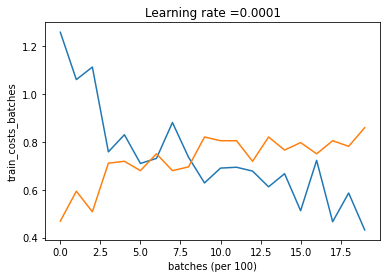

epoch,5
train loss,0.54298
train accuracy,0.81215
_runtime,18
_timestamp,1615557081
_step,9
val loss,0.55301
val accuracy,0.80483


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▂▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: 9tyj2rj2 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.2500781545679613
val accuracy for epoch  1 =  0.4668333333333333
train cost for epoch  1 =  1.67713070940527
train accuracy for epoch  1 =  0.3345740740740741

val cost for epoch  2 =  1.0526249448112792
val accuracy for epoch  2 =  0.5428333333333333
train cost for epoch  2 =  1.1291049593574243
train accuracy for epoch  2 =  0.5082592592592593

val cost for epoch  3 =  0.9627779686866205
val accuracy for epoch  3 =  0.6033333333333334
train cost for epoch  3 =  1.0101284838777995
train accuracy for epoch  3 =  0.591037037037037

val cost for epoch  4 =  0.9150786204883584
val accuracy for epoch  4 =  0.6316666666666667
train cost for epoch  4 =  0.9374319155571622
train accuracy for epoch  4 =  0.6300925925925925

val cost for epoch  5 =  0.883250066624938
val accuracy for epoch  5 =  0.6531666666666667
train cost for epoch  5 =  0.897893882535602
train accuracy for epoch  5 =  0.6516666666666666



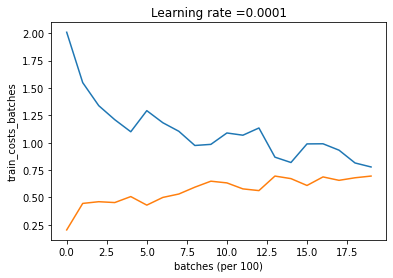

epoch,5
train loss,0.89789
train accuracy,0.65167
_runtime,18
_timestamp,1615557104
_step,9
val loss,0.88325
val accuracy,0.65317


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▅▇██
_runtime,▁▁▃▃▅▅▆▇▇█
_timestamp,▁▁▃▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: ctneo871 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5636629096380473
val accuracy for epoch  1 =  0.7906666666666666
train cost for epoch  1 =  0.7630387218018353
train accuracy for epoch  1 =  0.7109814814814814

val cost for epoch  2 =  0.5120168464720201
val accuracy for epoch  2 =  0.8221666666666667
train cost for epoch  2 =  0.5265386527605107
train accuracy for epoch  2 =  0.8122222222222222

val cost for epoch  3 =  0.4875170181451956
val accuracy for epoch  3 =  0.8271666666666667
train cost for epoch  3 =  0.48365822707113965
train accuracy for epoch  3 =  0.8281296296296297

val cost for epoch  4 =  0.4677650982057036
val accuracy for epoch  4 =  0.8336666666666667
train cost for epoch  4 =  0.4599518934085343
train accuracy for epoch  4 =  0.8367962962962963

val cost for epoch  5 =  0.45734329449360017
val accuracy for epoch  5 =  0.84
train cost for epoch  5 =  0.444862196731184
train accuracy for epoch  5 =  0.8431666666666666



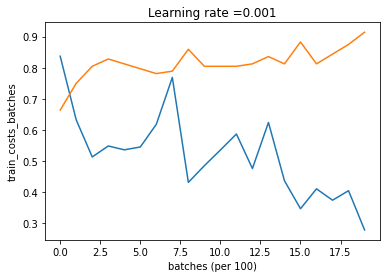

epoch,5
train loss,0.44486
train accuracy,0.84317
_runtime,17
_timestamp,1615557125
_step,9
val loss,0.45734
val accuracy,0.84


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▅▆▇█


wandb: Agent Starting Run: 7bl0rhfl with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7744978866223555
val accuracy for epoch  1 =  0.7076666666666667
train cost for epoch  1 =  1.0182183637092272
train accuracy for epoch  1 =  0.5948518518518519

val cost for epoch  2 =  0.6359442682169807
val accuracy for epoch  2 =  0.7646666666666667
train cost for epoch  2 =  0.6624569753856684
train accuracy for epoch  2 =  0.763462962962963

val cost for epoch  3 =  0.5750326431899319
val accuracy for epoch  3 =  0.7938333333333333
train cost for epoch  3 =  0.5743785579910464
train accuracy for epoch  3 =  0.8009814814814815

val cost for epoch  4 =  0.5302237800122586
val accuracy for epoch  4 =  0.8061666666666667
train cost for epoch  4 =  0.5199927721196759
train accuracy for epoch  4 =  0.8195185185185185

val cost for epoch  5 =  0.4909955350967999
val accuracy for epoch  5 =  0.8251666666666667
train cost for epoch  5 =  0.4910273567964383
train accuracy for epoch  5 =  0.8308333333333333



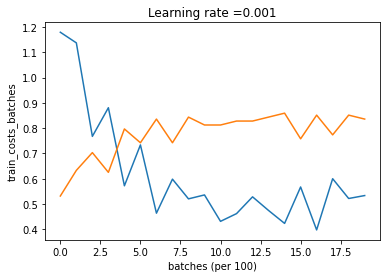

epoch,5
train loss,0.49103
train accuracy,0.83083
_runtime,18
_timestamp,1615557148
_step,9
val loss,0.491
val accuracy,0.82517


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: qaaer3ia with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.180868943090714
val accuracy for epoch  1 =  0.45566666666666666
train cost for epoch  1 =  1.4286498132140144
train accuracy for epoch  1 =  0.3708518518518519

val cost for epoch  2 =  1.0605014271677433
val accuracy for epoch  2 =  0.5306666666666666
train cost for epoch  2 =  1.1018312889142783
train accuracy for epoch  2 =  0.5270555555555556

val cost for epoch  3 =  0.9852573456474181
val accuracy for epoch  3 =  0.5883333333333334
train cost for epoch  3 =  1.0088464044629533
train accuracy for epoch  3 =  0.5817592592592593

val cost for epoch  4 =  0.9204430500259605
val accuracy for epoch  4 =  0.6406666666666667
train cost for epoch  4 =  0.943211224003633
train accuracy for epoch  4 =  0.6278148148148148

val cost for epoch  5 =  0.8424071511305771
val accuracy for epoch  5 =  0.6875
train cost for epoch  5 =  0.8756834734909601
train accuracy for epoch  5 =  0.6740185185185186



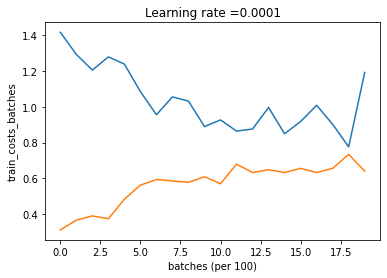

epoch,5
train loss,0.87568
train accuracy,0.67402
_runtime,20
_timestamp,1615557173
_step,9
val loss,0.84241
val accuracy,0.6875


epoch,▁▃▅▆█
train loss,█▄▃▂▁
train accuracy,▁▅▆▇█
_runtime,▁▁▂▃▄▅▆▇██
_timestamp,▁▁▂▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▄▃▁
val accuracy,▁▃▅▇█


wandb: Agent Starting Run: lrzvl6x3 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.4767006138693348
val accuracy for epoch  1 =  0.3425
train cost for epoch  1 =  1.8543487733721704
train accuracy for epoch  1 =  0.26242592592592595

val cost for epoch  2 =  1.3439108596302378
val accuracy for epoch  2 =  0.3885
train cost for epoch  2 =  1.392152165254022
train accuracy for epoch  2 =  0.36744444444444446

val cost for epoch  3 =  1.2779563381274555
val accuracy for epoch  3 =  0.4041666666666667
train cost for epoch  3 =  1.3073362380041
train accuracy for epoch  3 =  0.40246296296296297

val cost for epoch  4 =  1.2384577562404226
val accuracy for epoch  4 =  0.4211666666666667
train cost for epoch  4 =  1.2632149659463472
train accuracy for epoch  4 =  0.4173148148148148

val cost for epoch  5 =  1.2150912477024187
val accuracy for epoch  5 =  0.4251666666666667
train cost for epoch  5 =  1.2280590641970548
train accuracy for epoch  5 =  0.4340925925925926



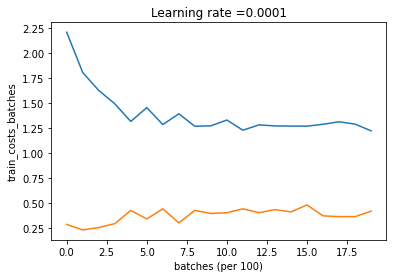

epoch,5
train loss,1.22806
train accuracy,0.43409
_runtime,22
_timestamp,1615557200
_step,9
val loss,1.21509
val accuracy,0.42517


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▅▇▇█
_runtime,▁▁▂▃▄▅▆▆██
_timestamp,▁▁▂▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▆██


wandb: Agent Starting Run: k8aeazay with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7562086841839816
val accuracy for epoch  1 =  0.7216666666666667
train cost for epoch  1 =  1.032591563790891
train accuracy for epoch  1 =  0.5741296296296297

val cost for epoch  2 =  0.6307355437447227
val accuracy for epoch  2 =  0.7786666666666666
train cost for epoch  2 =  0.6581851960544771
train accuracy for epoch  2 =  0.7655185185185185

val cost for epoch  3 =  0.563591139341022
val accuracy for epoch  3 =  0.798
train cost for epoch  3 =  0.5782176611534616
train accuracy for epoch  3 =  0.7974629629629629

val cost for epoch  4 =  0.5329691444716291
val accuracy for epoch  4 =  0.8086666666666666
train cost for epoch  4 =  0.5349920203720581
train accuracy for epoch  4 =  0.8145925925925926

val cost for epoch  5 =  0.5371424431146132
val accuracy for epoch  5 =  0.8141666666666667
train cost for epoch  5 =  0.5099897808947673
train accuracy for epoch  5 =  0.8228148148148148



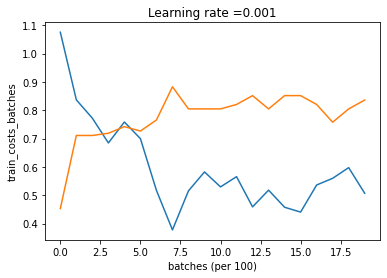

epoch,5
train loss,0.50999
train accuracy,0.82281
_runtime,21
_timestamp,1615557227
_step,9
val loss,0.53714
val accuracy,0.81417


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▂▃▄▅▆▆▇█
_timestamp,▁▁▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▁▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: gnbz5gl1 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.1710890736518886
val accuracy for epoch  1 =  0.5088333333333334
train cost for epoch  1 =  1.349896850162955
train accuracy for epoch  1 =  0.40635185185185185

val cost for epoch  2 =  1.0694180299980407
val accuracy for epoch  2 =  0.558
train cost for epoch  2 =  1.089737258245629
train accuracy for epoch  2 =  0.5375185185185185

val cost for epoch  3 =  0.9640575076000097
val accuracy for epoch  3 =  0.5821666666666667
train cost for epoch  3 =  1.0153595433030485
train accuracy for epoch  3 =  0.5700185185185185

val cost for epoch  4 =  0.9088295193016591
val accuracy for epoch  4 =  0.648
train cost for epoch  4 =  0.9493197154675852
train accuracy for epoch  4 =  0.6093148148148149

val cost for epoch  5 =  0.812219916973973
val accuracy for epoch  5 =  0.676
train cost for epoch  5 =  0.8524884648053666
train accuracy for epoch  5 =  0.6576666666666666



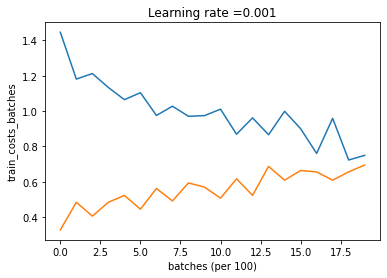

epoch,5
train loss,0.85249
train accuracy,0.65767
_runtime,19
_timestamp,1615557250
_step,9
val loss,0.81222
val accuracy,0.676


epoch,▁▃▅▆█
train loss,█▄▃▂▁
train accuracy,▁▅▆▇█
_runtime,▁▂▃▃▄▅▆▇██
_timestamp,▁▂▃▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▄▃▁
val accuracy,▁▃▄▇█


wandb: Agent Starting Run: xdl16z5o with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6412167796350993
val accuracy for epoch  1 =  0.7646666666666667
train cost for epoch  1 =  0.9301211597643071
train accuracy for epoch  1 =  0.6435555555555555

val cost for epoch  2 =  0.5209373068556046
val accuracy for epoch  2 =  0.8173333333333334
train cost for epoch  2 =  0.5627330644731047
train accuracy for epoch  2 =  0.8024074074074075

val cost for epoch  3 =  0.44699399804987827
val accuracy for epoch  3 =  0.8368333333333333
train cost for epoch  3 =  0.4730977156015307
train accuracy for epoch  3 =  0.8348518518518518

val cost for epoch  4 =  0.42099901815475793
val accuracy for epoch  4 =  0.8485
train cost for epoch  4 =  0.42805123121576605
train accuracy for epoch  4 =  0.8495370370370371

val cost for epoch  5 =  0.41455890811447593
val accuracy for epoch  5 =  0.8543333333333333
train cost for epoch  5 =  0.4003830066570962
train accuracy for epoch  5 =  0.8592962962962963



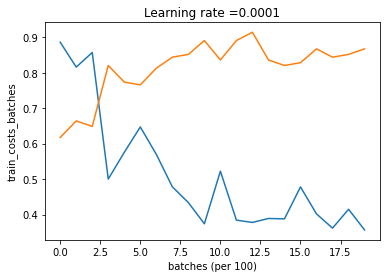

epoch,5
train loss,0.40038
train accuracy,0.8593
_runtime,33
_timestamp,1615557288
_step,9
val loss,0.41456
val accuracy,0.85433


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▁▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: 0ft4r4qb with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.9874292523937429
val accuracy for epoch  1 =  0.5996666666666667
train cost for epoch  1 =  1.3792674412125112
train accuracy for epoch  1 =  0.4587962962962963

val cost for epoch  2 =  0.8715844679234303
val accuracy for epoch  2 =  0.6508333333333334
train cost for epoch  2 =  0.9169211876684683
train accuracy for epoch  2 =  0.6398703703703704

val cost for epoch  3 =  0.792487821182356
val accuracy for epoch  3 =  0.6855
train cost for epoch  3 =  0.8298343648653396
train accuracy for epoch  3 =  0.6752777777777778

val cost for epoch  4 =  0.7358688511043274
val accuracy for epoch  4 =  0.7145
train cost for epoch  4 =  0.7612983258022472
train accuracy for epoch  4 =  0.7097407407407408

val cost for epoch  5 =  0.6816312846659689
val accuracy for epoch  5 =  0.7441666666666666
train cost for epoch  5 =  0.7041650566786022
train accuracy for epoch  5 =  0.7401851851851852



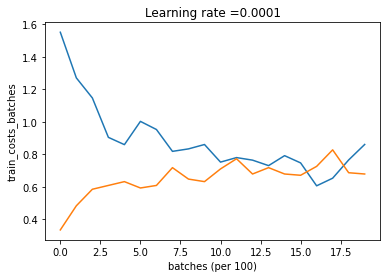

epoch,5
train loss,0.70417
train accuracy,0.74019
_runtime,34
_timestamp,1615557327
_step,9
val loss,0.68163
val accuracy,0.74417


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▆▇█
_runtime,▁▁▃▃▄▄▆▆▇█
_timestamp,▁▁▃▃▄▄▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▄▂▁
val accuracy,▁▃▅▇█


wandb: Agent Starting Run: 4yp0nh6b with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5597473801108888
val accuracy for epoch  1 =  0.805
train cost for epoch  1 =  0.661799348948366
train accuracy for epoch  1 =  0.7551296296296296

val cost for epoch  2 =  0.5105697388934892
val accuracy for epoch  2 =  0.8206666666666667
train cost for epoch  2 =  0.49257526789050154
train accuracy for epoch  2 =  0.8275

val cost for epoch  3 =  0.49620178693835304
val accuracy for epoch  3 =  0.8245
train cost for epoch  3 =  0.45988834685751595
train accuracy for epoch  3 =  0.8388148148148148

val cost for epoch  4 =  0.49461549505026753
val accuracy for epoch  4 =  0.8295
train cost for epoch  4 =  0.4420109262248159
train accuracy for epoch  4 =  0.8438333333333333

val cost for epoch  5 =  0.45302559560956784
val accuracy for epoch  5 =  0.8363333333333334
train cost for epoch  5 =  0.42339885049499687
train accuracy for epoch  5 =  0.8491296296296297



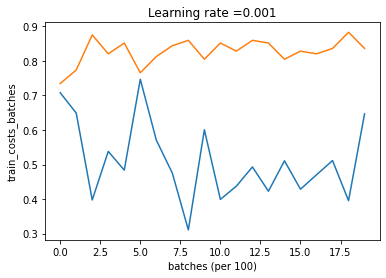

epoch,5
train loss,0.4234
train accuracy,0.84913
_runtime,29
_timestamp,1615557363
_step,9
val loss,0.45303
val accuracy,0.83633


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▄▄▁
val accuracy,▁▅▅▆█


wandb: Agent Starting Run: kpkfgtfq with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6131940916212137
val accuracy for epoch  1 =  0.7795
train cost for epoch  1 =  0.8270516819478859
train accuracy for epoch  1 =  0.6775

val cost for epoch  2 =  0.4825237126987024
val accuracy for epoch  2 =  0.8265
train cost for epoch  2 =  0.5192471049167983
train accuracy for epoch  2 =  0.8154074074074074

val cost for epoch  3 =  0.45827431650276224
val accuracy for epoch  3 =  0.832
train cost for epoch  3 =  0.4489502119570201
train accuracy for epoch  3 =  0.8411296296296297

val cost for epoch  4 =  0.4445068036891898
val accuracy for epoch  4 =  0.8405
train cost for epoch  4 =  0.41174881213733006
train accuracy for epoch  4 =  0.8540555555555556

val cost for epoch  5 =  0.4099529425067721
val accuracy for epoch  5 =  0.86
train cost for epoch  5 =  0.3887143338812799
train accuracy for epoch  5 =  0.8615



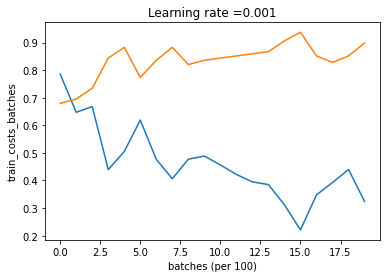

epoch,5
train loss,0.38871
train accuracy,0.8615
_runtime,29
_timestamp,1615557397
_step,9
val loss,0.40995
val accuracy,0.86


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▃▂▁
val accuracy,▁▅▆▆█


wandb: Agent Starting Run: ih99xf4e with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6021842999964256
val accuracy for epoch  1 =  0.7871666666666667
train cost for epoch  1 =  0.8273122240083737
train accuracy for epoch  1 =  0.7076296296296296

val cost for epoch  2 =  0.5571338949965068
val accuracy for epoch  2 =  0.8026666666666666
train cost for epoch  2 =  0.5600858414764253
train accuracy for epoch  2 =  0.8065555555555556

val cost for epoch  3 =  0.5072121739334643
val accuracy for epoch  3 =  0.8175
train cost for epoch  3 =  0.5163138553440575
train accuracy for epoch  3 =  0.8214259259259259

val cost for epoch  4 =  0.49728924354890286
val accuracy for epoch  4 =  0.821
train cost for epoch  4 =  0.4865048365705875
train accuracy for epoch  4 =  0.8300555555555555

val cost for epoch  5 =  0.48419860416246685
val accuracy for epoch  5 =  0.8281666666666667
train cost for epoch  5 =  0.47328143997874117
train accuracy for epoch  5 =  0.8324814814814815



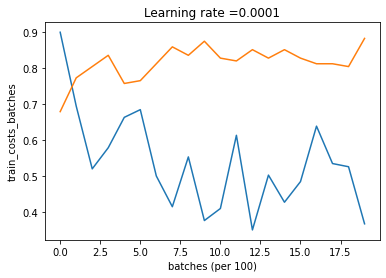

epoch,5
train loss,0.47328
train accuracy,0.83248
_runtime,13
_timestamp,1615557417
_step,9
val loss,0.4842
val accuracy,0.82817


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▇▇██
_runtime,▁▂▃▄▅▅▆▆▇█
_timestamp,▁▂▃▄▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▂▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: puj6ttjt with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7495019825993683
val accuracy for epoch  1 =  0.7223333333333334
train cost for epoch  1 =  1.0808866527948289
train accuracy for epoch  1 =  0.6142407407407408

val cost for epoch  2 =  0.6267093810800937
val accuracy for epoch  2 =  0.78
train cost for epoch  2 =  0.6653371186803069
train accuracy for epoch  2 =  0.766

val cost for epoch  3 =  0.5733195320605887
val accuracy for epoch  3 =  0.7998333333333333
train cost for epoch  3 =  0.5821056075193585
train accuracy for epoch  3 =  0.7998518518518518

val cost for epoch  4 =  0.5446939141953567
val accuracy for epoch  4 =  0.8093333333333333
train cost for epoch  4 =  0.5421299442574458
train accuracy for epoch  4 =  0.8150185185185185

val cost for epoch  5 =  0.5176552683481288
val accuracy for epoch  5 =  0.8165
train cost for epoch  5 =  0.5158213360105669
train accuracy for epoch  5 =  0.8235555555555556



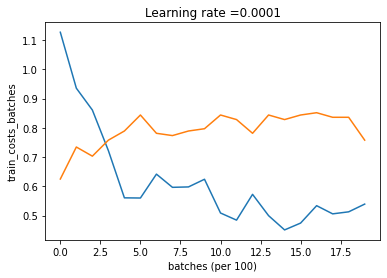

epoch,5
train loss,0.51582
train accuracy,0.82356
_runtime,14
_timestamp,1615557436
_step,9
val loss,0.51766
val accuracy,0.8165


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▄▅▅▇▇██
_timestamp,▁▂▃▄▅▅▇▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▇▇█


wandb: Agent Starting Run: 8velekd7 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5810067916397226
val accuracy for epoch  1 =  0.7841666666666667
train cost for epoch  1 =  0.6892950463993789
train accuracy for epoch  1 =  0.7478888888888889

val cost for epoch  2 =  0.6313045501265623
val accuracy for epoch  2 =  0.7586666666666667
train cost for epoch  2 =  0.5922158555449731
train accuracy for epoch  2 =  0.7832407407407408

val cost for epoch  3 =  0.6023527712516372
val accuracy for epoch  3 =  0.7683333333333333
train cost for epoch  3 =  0.5646307894228487
train accuracy for epoch  3 =  0.7926851851851852

val cost for epoch  4 =  0.5683596097281147
val accuracy for epoch  4 =  0.7948333333333333
train cost for epoch  4 =  0.5447735821200648
train accuracy for epoch  4 =  0.8000185185185186

val cost for epoch  5 =  0.5400492799855224
val accuracy for epoch  5 =  0.8081666666666667
train cost for epoch  5 =  0.5278074362011606
train accuracy for epoch  5 =  0.8090740740740741



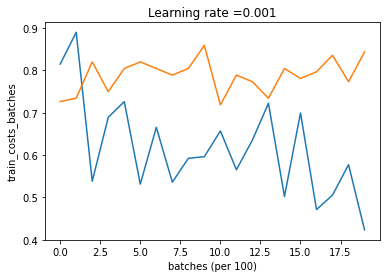

epoch,5
train loss,0.52781
train accuracy,0.80907
_runtime,13
_timestamp,1615557454
_step,9
val loss,0.54005
val accuracy,0.80817


epoch,▁▃▅▆█
train loss,█▄▃▂▁
train accuracy,▁▅▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,▄█▆▃▁
val accuracy,▅▁▂▆█


wandb: Agent Starting Run: d32lg923 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5538669621260837
val accuracy for epoch  1 =  0.7971666666666667
train cost for epoch  1 =  0.6981618963128299
train accuracy for epoch  1 =  0.7461296296296296

val cost for epoch  2 =  0.5423606355257246
val accuracy for epoch  2 =  0.8036666666666666
train cost for epoch  2 =  0.519873371402423
train accuracy for epoch  2 =  0.8141481481481482

val cost for epoch  3 =  0.49712655605873235
val accuracy for epoch  3 =  0.823
train cost for epoch  3 =  0.4844564303877129
train accuracy for epoch  3 =  0.8256851851851852

val cost for epoch  4 =  0.5090216420331959
val accuracy for epoch  4 =  0.814
train cost for epoch  4 =  0.4666308927468444
train accuracy for epoch  4 =  0.8335370370370371

val cost for epoch  5 =  0.48905606682701225
val accuracy for epoch  5 =  0.8258333333333333
train cost for epoch  5 =  0.4575210620476213
train accuracy for epoch  5 =  0.835462962962963



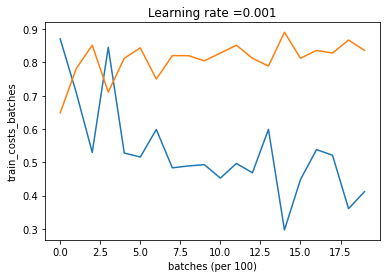

epoch,5
train loss,0.45752
train accuracy,0.83546
_runtime,13
_timestamp,1615557474
_step,9
val loss,0.48906
val accuracy,0.82583


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▂▃▅▅▆▇▇█
_timestamp,▁▂▂▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▇▂▃▁
val accuracy,▁▃▇▅█


wandb: Agent Starting Run: wmbn2krf with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4892405480795641
val accuracy for epoch  1 =  0.826
train cost for epoch  1 =  0.6757618206668964
train accuracy for epoch  1 =  0.7627222222222222

val cost for epoch  2 =  0.440700898405709
val accuracy for epoch  2 =  0.845
train cost for epoch  2 =  0.4534427629449721
train accuracy for epoch  2 =  0.8402407407407407

val cost for epoch  3 =  0.40078771983566497
val accuracy for epoch  3 =  0.8566666666666667
train cost for epoch  3 =  0.4137867667628578
train accuracy for epoch  3 =  0.854574074074074

val cost for epoch  4 =  0.40064965952941406
val accuracy for epoch  4 =  0.8566666666666667
train cost for epoch  4 =  0.38756778221181426
train accuracy for epoch  4 =  0.8612037037037037

val cost for epoch  5 =  0.3922036619316187
val accuracy for epoch  5 =  0.8581666666666666
train cost for epoch  5 =  0.3744884992560698
train accuracy for epoch  5 =  0.8673148148148148



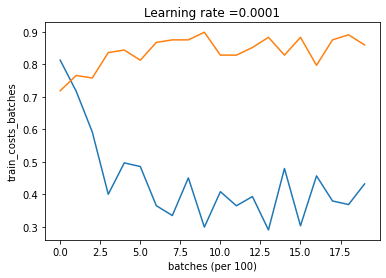

epoch,5
train loss,0.37449
train accuracy,0.86731
_runtime,15
_timestamp,1615557497
_step,9
val loss,0.3922
val accuracy,0.85817


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▄▄▅▆▆▇█
_timestamp,▁▂▃▄▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▂▁
val accuracy,▁▅███


wandb: Agent Starting Run: ppioy39t with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6755476223677861
val accuracy for epoch  1 =  0.7533333333333333
train cost for epoch  1 =  0.9611913736092546
train accuracy for epoch  1 =  0.6708148148148149

val cost for epoch  2 =  0.5688637498917668
val accuracy for epoch  2 =  0.8051666666666667
train cost for epoch  2 =  0.5924047883931586
train accuracy for epoch  2 =  0.7968333333333333

val cost for epoch  3 =  0.5119072655192777
val accuracy for epoch  3 =  0.8201666666666667
train cost for epoch  3 =  0.5221684714709094
train accuracy for epoch  3 =  0.8214444444444444

val cost for epoch  4 =  0.48579353828128924
val accuracy for epoch  4 =  0.8273333333333334
train cost for epoch  4 =  0.4832126285403669
train accuracy for epoch  4 =  0.834

val cost for epoch  5 =  0.4571178883799872
val accuracy for epoch  5 =  0.8376666666666667
train cost for epoch  5 =  0.4598106517021718
train accuracy for epoch  5 =  0.8423333333333334



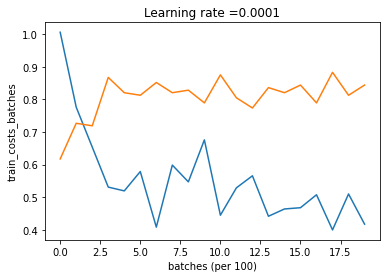

epoch,5
train loss,0.45981
train accuracy,0.84233
_runtime,16
_timestamp,1615557518
_step,9
val loss,0.45712
val accuracy,0.83767


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▇██
_timestamp,▁▁▃▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▅▇▇█


wandb: Agent Starting Run: vbdsmebs with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5749798271692199
val accuracy for epoch  1 =  0.7891666666666667
train cost for epoch  1 =  0.6508262598819358
train accuracy for epoch  1 =  0.7652407407407408

val cost for epoch  2 =  0.6053697721500232
val accuracy for epoch  2 =  0.7806666666666666
train cost for epoch  2 =  0.5596677037798978
train accuracy for epoch  2 =  0.8013703703703704

val cost for epoch  3 =  0.5384525232296864
val accuracy for epoch  3 =  0.8071666666666667
train cost for epoch  3 =  0.5331263979438923
train accuracy for epoch  3 =  0.8141666666666667

val cost for epoch  4 =  0.5612660270741074
val accuracy for epoch  4 =  0.7926666666666666
train cost for epoch  4 =  0.5315096981988692
train accuracy for epoch  4 =  0.8151851851851852

val cost for epoch  5 =  0.5502147948090309
val accuracy for epoch  5 =  0.8013333333333333
train cost for epoch  5 =  0.5353852016041365
train accuracy for epoch  5 =  0.8129259259259259



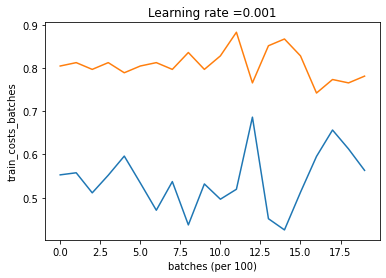

epoch,5
train loss,0.53539
train accuracy,0.81293
_runtime,16
_timestamp,1615557541
_step,9
val loss,0.55021
val accuracy,0.80133


epoch,▁▃▅▆█
train loss,█▃▁▁▁
train accuracy,▁▆███
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,▅█▁▃▂
val accuracy,▃▁█▄▆


wandb: Agent Starting Run: kl2ry0f6 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.49505765767829657
val accuracy for epoch  1 =  0.8163333333333334
train cost for epoch  1 =  0.618037918043791
train accuracy for epoch  1 =  0.7773703703703704

val cost for epoch  2 =  0.4402770856957514
val accuracy for epoch  2 =  0.8396666666666667
train cost for epoch  2 =  0.4565873346311354
train accuracy for epoch  2 =  0.8372962962962963

val cost for epoch  3 =  0.43147906572116085
val accuracy for epoch  3 =  0.8413333333333334
train cost for epoch  3 =  0.4217722008810132
train accuracy for epoch  3 =  0.8474444444444444

val cost for epoch  4 =  0.4222257317677979
val accuracy for epoch  4 =  0.8553333333333333
train cost for epoch  4 =  0.39848782520624965
train accuracy for epoch  4 =  0.8570555555555556

val cost for epoch  5 =  0.414281305523303
val accuracy for epoch  5 =  0.85
train cost for epoch  5 =  0.3831337694296745
train accuracy for epoch  5 =  0.863037037037037



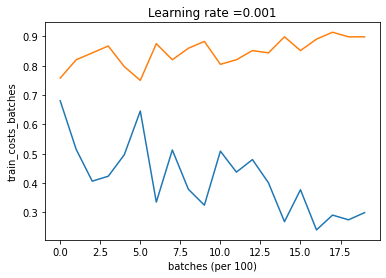

epoch,5
train loss,0.38313
train accuracy,0.86304
_runtime,17
_timestamp,1615557564
_step,9
val loss,0.41428
val accuracy,0.85


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▅▅▆▆▇█
_timestamp,▁▂▃▃▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▂▂▁
val accuracy,▁▅▅█▇


wandb: Agent Starting Run: d0mczvt3 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.45431445759658245
val accuracy for epoch  1 =  0.8318333333333333
train cost for epoch  1 =  0.6234895147418785
train accuracy for epoch  1 =  0.7844074074074074

val cost for epoch  2 =  0.4243034561027528
val accuracy for epoch  2 =  0.8453333333333334
train cost for epoch  2 =  0.43108823257317797
train accuracy for epoch  2 =  0.8472777777777778

val cost for epoch  3 =  0.393851099315289
val accuracy for epoch  3 =  0.857
train cost for epoch  3 =  0.3866401992626204
train accuracy for epoch  3 =  0.8633888888888889

val cost for epoch  4 =  0.39244368985655387
val accuracy for epoch  4 =  0.8576666666666667
train cost for epoch  4 =  0.3632704050970947
train accuracy for epoch  4 =  0.8696481481481482

val cost for epoch  5 =  0.36530153225501644
val accuracy for epoch  5 =  0.8688333333333333
train cost for epoch  5 =  0.3491851431815195
train accuracy for epoch  5 =  0.8752407407407408



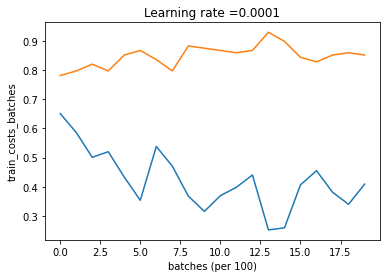

epoch,5
train loss,0.34919
train accuracy,0.87524
_runtime,26
_timestamp,1615557595
_step,9
val loss,0.3653
val accuracy,0.86883


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▃▃▁
val accuracy,▁▄▆▆█


wandb: Agent Starting Run: 6oqowty7 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6160792533434368
val accuracy for epoch  1 =  0.7816666666666666
train cost for epoch  1 =  0.867141024208833
train accuracy for epoch  1 =  0.709037037037037

val cost for epoch  2 =  0.533575130557086
val accuracy for epoch  2 =  0.8173333333333334
train cost for epoch  2 =  0.5497418498881864
train accuracy for epoch  2 =  0.8115740740740741

val cost for epoch  3 =  0.48909699630417414
val accuracy for epoch  3 =  0.8266666666666667
train cost for epoch  3 =  0.48843162051096195
train accuracy for epoch  3 =  0.8347777777777777

val cost for epoch  4 =  0.459821383319221
val accuracy for epoch  4 =  0.8381666666666666
train cost for epoch  4 =  0.4554685758094356
train accuracy for epoch  4 =  0.8442037037037037

val cost for epoch  5 =  0.44913236930365635
val accuracy for epoch  5 =  0.842
train cost for epoch  5 =  0.43336601022468496
train accuracy for epoch  5 =  0.8523148148148149



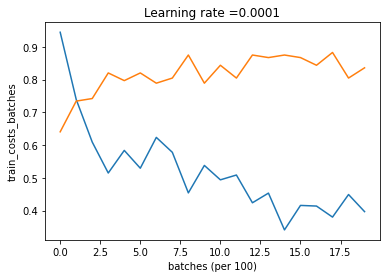

epoch,5
train loss,0.43337
train accuracy,0.85231
_runtime,25
_timestamp,1615557624
_step,9
val loss,0.44913
val accuracy,0.842


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▇██
_timestamp,▁▁▃▃▅▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▁▁
val accuracy,▁▅▆██


wandb: Agent Starting Run: idewxhn6 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6208417577502722
val accuracy for epoch  1 =  0.778
train cost for epoch  1 =  0.6558942066801211
train accuracy for epoch  1 =  0.7602037037037037

val cost for epoch  2 =  0.5843848017999719
val accuracy for epoch  2 =  0.7975
train cost for epoch  2 =  0.5823371367033678
train accuracy for epoch  2 =  0.7959444444444445

val cost for epoch  3 =  0.5791334926044931
val accuracy for epoch  3 =  0.8008333333333333
train cost for epoch  3 =  0.5411051057690615
train accuracy for epoch  3 =  0.8119814814814815

val cost for epoch  4 =  0.5502254907291879
val accuracy for epoch  4 =  0.812
train cost for epoch  4 =  0.5297818759129258
train accuracy for epoch  4 =  0.814037037037037

val cost for epoch  5 =  0.5384757294036345
val accuracy for epoch  5 =  0.8085
train cost for epoch  5 =  0.5169565379760969
train accuracy for epoch  5 =  0.8202222222222222



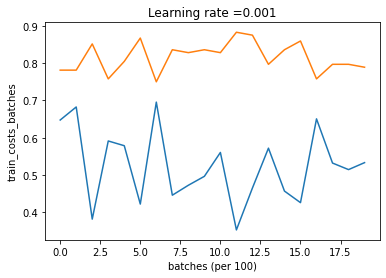

epoch,5
train loss,0.51696
train accuracy,0.82022
_runtime,22
_timestamp,1615557651
_step,9
val loss,0.53848
val accuracy,0.8085


epoch,▁▃▅▆█
train loss,█▄▂▂▁
train accuracy,▁▅▇▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▄▂▁
val accuracy,▁▅▆█▇


wandb: Agent Starting Run: ewvbpw41 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.458311050904158
val accuracy for epoch  1 =  0.8336666666666667
train cost for epoch  1 =  0.5773818101238575
train accuracy for epoch  1 =  0.7922592592592592

val cost for epoch  2 =  0.4169259190430452
val accuracy for epoch  2 =  0.8481666666666666
train cost for epoch  2 =  0.42253397470015436
train accuracy for epoch  2 =  0.8479629629629629

val cost for epoch  3 =  0.39477932406929056
val accuracy for epoch  3 =  0.8511666666666666
train cost for epoch  3 =  0.38961689988178266
train accuracy for epoch  3 =  0.861

val cost for epoch  4 =  0.3915884939846595
val accuracy for epoch  4 =  0.8618333333333333
train cost for epoch  4 =  0.3636848329475747
train accuracy for epoch  4 =  0.8699444444444444

val cost for epoch  5 =  0.392893696955476
val accuracy for epoch  5 =  0.8565
train cost for epoch  5 =  0.3451253493841308
train accuracy for epoch  5 =  0.8739629629629629



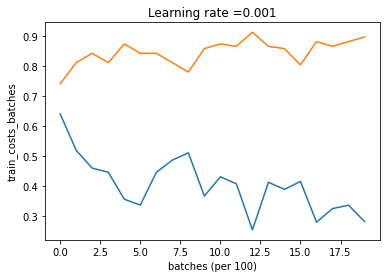

epoch,5
train loss,0.34513
train accuracy,0.87396
_runtime,23
_timestamp,1615557679
_step,9
val loss,0.39289
val accuracy,0.8565


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▁▁▁
val accuracy,▁▅▅█▇


wandb: Agent Starting Run: upmnm2mx with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4430348425349012
val accuracy for epoch  1 =  0.8413333333333334
train cost for epoch  1 =  0.5861033698723251
train accuracy for epoch  1 =  0.7953148148148148

val cost for epoch  2 =  0.4167710634350876
val accuracy for epoch  2 =  0.8498333333333333
train cost for epoch  2 =  0.41424508129320065
train accuracy for epoch  2 =  0.852537037037037

val cost for epoch  3 =  0.3899961958404238
val accuracy for epoch  3 =  0.857
train cost for epoch  3 =  0.37033857487212757
train accuracy for epoch  3 =  0.8685185185185185

val cost for epoch  4 =  0.36098234767933973
val accuracy for epoch  4 =  0.868
train cost for epoch  4 =  0.34712157217198747
train accuracy for epoch  4 =  0.8756111111111111

val cost for epoch  5 =  0.3728302738903796
val accuracy for epoch  5 =  0.8653333333333333
train cost for epoch  5 =  0.3288009905501893
train accuracy for epoch  5 =  0.8821851851851852



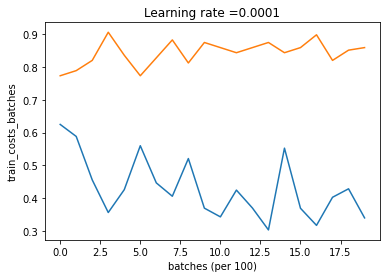

epoch,5
train loss,0.3288
train accuracy,0.88219
_runtime,70
_timestamp,1615557754
_step,9
val loss,0.37283
val accuracy,0.86533


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇▇█
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▃▁▂
val accuracy,▁▃▅█▇


wandb: Agent Starting Run: a8gxn80j with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5846804480736421
val accuracy for epoch  1 =  0.7921666666666667
train cost for epoch  1 =  0.7968971683233412
train accuracy for epoch  1 =  0.7318333333333333

val cost for epoch  2 =  0.48435624989424947
val accuracy for epoch  2 =  0.8291666666666667
train cost for epoch  2 =  0.5113363124403433
train accuracy for epoch  2 =  0.824962962962963

val cost for epoch  3 =  0.4635944607878387
val accuracy for epoch  3 =  0.8365
train cost for epoch  3 =  0.4594357252562181
train accuracy for epoch  3 =  0.8431296296296297

val cost for epoch  4 =  0.4453946251626684
val accuracy for epoch  4 =  0.8446666666666667
train cost for epoch  4 =  0.42826262942916316
train accuracy for epoch  4 =  0.8538518518518519

val cost for epoch  5 =  0.41844417727639327
val accuracy for epoch  5 =  0.849
train cost for epoch  5 =  0.40702631898279107
train accuracy for epoch  5 =  0.8588888888888889



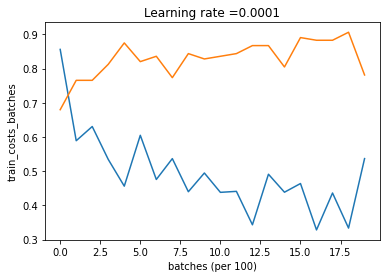

epoch,5
train loss,0.40703
train accuracy,0.85889
_runtime,81
_timestamp,1615557840
_step,9
val loss,0.41844
val accuracy,0.849


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▆▆▇█


wandb: Agent Starting Run: trj7qmf5 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6002942033532176
val accuracy for epoch  1 =  0.7681666666666667
train cost for epoch  1 =  0.646414779809758
train accuracy for epoch  1 =  0.769

val cost for epoch  2 =  0.5545851319640893
val accuracy for epoch  2 =  0.8073333333333333
train cost for epoch  2 =  0.5582294994638306
train accuracy for epoch  2 =  0.8020555555555555

val cost for epoch  3 =  0.5690107895259433
val accuracy for epoch  3 =  0.8116666666666666
train cost for epoch  3 =  0.5345900433901457
train accuracy for epoch  3 =  0.8137222222222222

val cost for epoch  4 =  0.49886477391070994
val accuracy for epoch  4 =  0.8231666666666667
train cost for epoch  4 =  0.5029800235955146
train accuracy for epoch  4 =  0.8233518518518519

val cost for epoch  5 =  0.5409142607974449
val accuracy for epoch  5 =  0.8143333333333334
train cost for epoch  5 =  0.5024759362750278
train accuracy for epoch  5 =  0.823925925925926



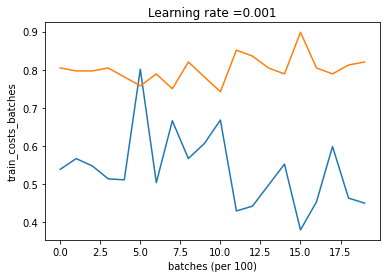

epoch,5
train loss,0.50248
train accuracy,0.82393
_runtime,69
_timestamp,1615557915
_step,9
val loss,0.54091
val accuracy,0.81433


epoch,▁▃▅▆█
train loss,█▄▃▁▁
train accuracy,▁▅▇██
_runtime,▁▁▃▃▄▄▆▆██
_timestamp,▁▁▃▃▄▄▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▆▁▄
val accuracy,▁▆▇█▇


wandb: Agent Starting Run: haf08gtv with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4594122098538108
val accuracy for epoch  1 =  0.832
train cost for epoch  1 =  0.5906726012787288
train accuracy for epoch  1 =  0.789537037037037

val cost for epoch  2 =  0.4062612273162662
val accuracy for epoch  2 =  0.849
train cost for epoch  2 =  0.42407486645092873
train accuracy for epoch  2 =  0.8456296296296296

val cost for epoch  3 =  0.4007224485718677
val accuracy for epoch  3 =  0.8546666666666667
train cost for epoch  3 =  0.3883833823220373
train accuracy for epoch  3 =  0.8617962962962963

val cost for epoch  4 =  0.3771871245961338
val accuracy for epoch  4 =  0.863
train cost for epoch  4 =  0.36594700249651685
train accuracy for epoch  4 =  0.8673148148148148

val cost for epoch  5 =  0.40084421400227516
val accuracy for epoch  5 =  0.8548333333333333
train cost for epoch  5 =  0.345303355296961
train accuracy for epoch  5 =  0.8742592592592593



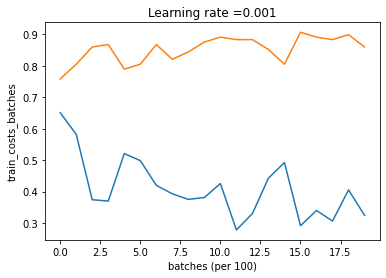

epoch,5
train loss,0.3453
train accuracy,0.87426
_runtime,81
_timestamp,1615558001
_step,9
val loss,0.40084
val accuracy,0.85483


epoch,▁▃▅▆█
train loss,█▃▂▂▁
train accuracy,▁▆▇▇█
_runtime,▁▁▃▃▄▄▆▆██
_timestamp,▁▁▃▃▄▄▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▃▁▃
val accuracy,▁▅▆█▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kgyrrjoh with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.8259028924222659
val accuracy for epoch  1 =  0.6681666666666667
train cost for epoch  1 =  1.123616613300192
train accuracy for epoch  1 =  0.5526296296296296

val cost for epoch  2 =  0.6749150588024265
val accuracy for epoch  2 =  0.7525
train cost for epoch  2 =  0.7315319509123577
train accuracy for epoch  2 =  0.7309074074074075

val cost for epoch  3 =  0.5985555015618358
val accuracy for epoch  3 =  0.7843333333333333
train cost for epoch  3 =  0.6248883640434528
train accuracy for epoch  3 =  0.7783518518518519

val cost for epoch  4 =  0.5652038878881582
val accuracy for epoch  4 =  0.7998333333333333
train cost for epoch  4 =  0.5675203640917862
train accuracy for epoch  4 =  0.8014629629629629

val cost for epoch  5 =  0.5333825568317521
val accuracy for epoch  5 =  0.8058333333333333
train cost for epoch  5 =  0.5338916762945997
train accuracy for epoch  5 =  0.8147777777777778



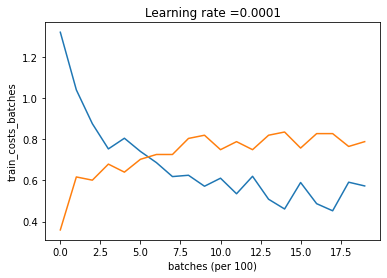

epoch,5
train loss,0.53389
train accuracy,0.81478
_runtime,15
_timestamp,1615558030
_step,9
val loss,0.53338
val accuracy,0.80583


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: qpwsgumo with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.3128842447005038
val accuracy for epoch  1 =  0.445
train cost for epoch  1 =  1.6772648092116105
train accuracy for epoch  1 =  0.3231851851851852

val cost for epoch  2 =  1.1228874463944452
val accuracy for epoch  2 =  0.5426666666666666
train cost for epoch  2 =  1.2030287821756904
train accuracy for epoch  2 =  0.49798148148148147

val cost for epoch  3 =  1.0196010078566178
val accuracy for epoch  3 =  0.5841666666666666
train cost for epoch  3 =  1.0625676159322694
train accuracy for epoch  3 =  0.5733703703703704

val cost for epoch  4 =  0.9667716008773191
val accuracy for epoch  4 =  0.6036666666666667
train cost for epoch  4 =  0.9862079407990381
train accuracy for epoch  4 =  0.6079629629629629

val cost for epoch  5 =  0.9326196501797699
val accuracy for epoch  5 =  0.6175
train cost for epoch  5 =  0.9437491431571802
train accuracy for epoch  5 =  0.6245740740740741



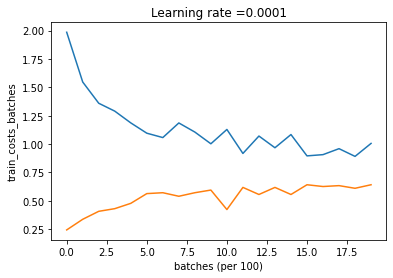

epoch,5
train loss,0.94375
train accuracy,0.62457
_runtime,18
_timestamp,1615558052
_step,9
val loss,0.93262
val accuracy,0.6175


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▅▇██
_runtime,▁▁▃▃▅▅▆▇▇█
_timestamp,▁▁▃▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▅▇▇█


wandb: Agent Starting Run: sdkq69h6 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5986873396488381
val accuracy for epoch  1 =  0.78
train cost for epoch  1 =  0.7929391276334019
train accuracy for epoch  1 =  0.6974074074074074

val cost for epoch  2 =  0.5573814496204618
val accuracy for epoch  2 =  0.7943333333333333
train cost for epoch  2 =  0.571567436428962
train accuracy for epoch  2 =  0.7987592592592593

val cost for epoch  3 =  0.5200560553363589
val accuracy for epoch  3 =  0.8171666666666667
train cost for epoch  3 =  0.5298385842057051
train accuracy for epoch  3 =  0.8157962962962962

val cost for epoch  4 =  0.5308159878012899
val accuracy for epoch  4 =  0.8151666666666667
train cost for epoch  4 =  0.51112394957828
train accuracy for epoch  4 =  0.8213703703703704

val cost for epoch  5 =  0.49530889237364256
val accuracy for epoch  5 =  0.8175
train cost for epoch  5 =  0.5016749309535649
train accuracy for epoch  5 =  0.8263148148148148



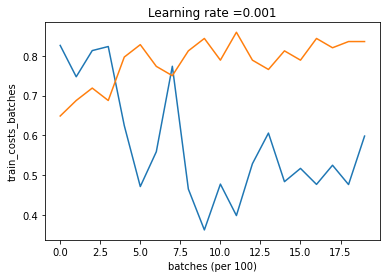

epoch,5
train loss,0.50167
train accuracy,0.82631
_runtime,16
_timestamp,1615558073
_step,9
val loss,0.49531
val accuracy,0.8175


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▇▇██
_runtime,▁▂▃▃▅▅▆▇▇█
_timestamp,▁▂▃▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▃▁
val accuracy,▁▄███


wandb: Agent Starting Run: ih3sq3c6 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 32-64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7367372511966196
val accuracy for epoch  1 =  0.7295
train cost for epoch  1 =  1.0110577122394258
train accuracy for epoch  1 =  0.6082592592592593

val cost for epoch  2 =  0.5961370243833604
val accuracy for epoch  2 =  0.7765
train cost for epoch  2 =  0.6541593007923291
train accuracy for epoch  2 =  0.7641296296296296

val cost for epoch  3 =  0.541437836469922
val accuracy for epoch  3 =  0.8105
train cost for epoch  3 =  0.5554374876015119
train accuracy for epoch  3 =  0.802037037037037

val cost for epoch  4 =  0.5062742467710194
val accuracy for epoch  4 =  0.813
train cost for epoch  4 =  0.5076963441450575
train accuracy for epoch  4 =  0.8215555555555556

val cost for epoch  5 =  0.4806729381767373
val accuracy for epoch  5 =  0.8233333333333334
train cost for epoch  5 =  0.48301118324016024
train accuracy for epoch  5 =  0.8304259259259259



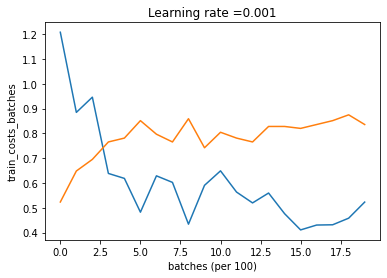

epoch,5
train loss,0.48301
train accuracy,0.83043
_runtime,17
_timestamp,1615558095
_step,9
val loss,0.48067
val accuracy,0.82333


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▂▁
val accuracy,▁▅▇▇█


wandb: Agent Starting Run: dehnxayw with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.8704836277397978
val accuracy for epoch  1 =  0.6496666666666666
train cost for epoch  1 =  1.1550292447729762
train accuracy for epoch  1 =  0.5387777777777778

val cost for epoch  2 =  0.6944426336846977
val accuracy for epoch  2 =  0.7385
train cost for epoch  2 =  0.7596743556757387
train accuracy for epoch  2 =  0.723

val cost for epoch  3 =  0.6227593474817883
val accuracy for epoch  3 =  0.7785
train cost for epoch  3 =  0.6494691494666975
train accuracy for epoch  3 =  0.769537037037037

val cost for epoch  4 =  0.5870781199607938
val accuracy for epoch  4 =  0.79
train cost for epoch  4 =  0.5972076970091885
train accuracy for epoch  4 =  0.7937777777777778

val cost for epoch  5 =  0.5617412519149974
val accuracy for epoch  5 =  0.7953333333333333
train cost for epoch  5 =  0.5573821821266902
train accuracy for epoch  5 =  0.807537037037037



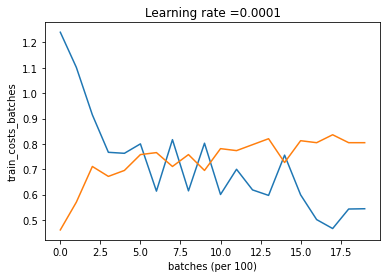

epoch,5
train loss,0.55738
train accuracy,0.80754
_runtime,19
_timestamp,1615558119
_step,9
val loss,0.56174
val accuracy,0.79533


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▂▃▄▅▆▇██
_timestamp,▁▁▂▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▂▁
val accuracy,▁▅▇██


wandb: Agent Starting Run: 3ceupbv2 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.2083247596930056
val accuracy for epoch  1 =  0.5116666666666667
train cost for epoch  1 =  1.6201100955178696
train accuracy for epoch  1 =  0.3872407407407407

val cost for epoch  2 =  1.0012501864105425
val accuracy for epoch  2 =  0.6033333333333334
train cost for epoch  2 =  1.079783303884619
train accuracy for epoch  2 =  0.5760185185185185

val cost for epoch  3 =  0.9313883549574165
val accuracy for epoch  3 =  0.6263333333333333
train cost for epoch  3 =  0.9619816557759291
train accuracy for epoch  3 =  0.6225

val cost for epoch  4 =  0.874534299232177
val accuracy for epoch  4 =  0.6456666666666667
train cost for epoch  4 =  0.9049511138905587
train accuracy for epoch  4 =  0.6463518518518518

val cost for epoch  5 =  0.8501834361535705
val accuracy for epoch  5 =  0.6671666666666667
train cost for epoch  5 =  0.8658766563999571
train accuracy for epoch  5 =  0.6653148148148148



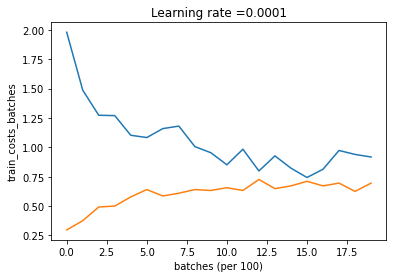

epoch,5
train loss,0.86588
train accuracy,0.66531
_runtime,18
_timestamp,1615558142
_step,9
val loss,0.85018
val accuracy,0.66717


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▅▅▆▇▇█
_timestamp,▁▂▃▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▃▁▁
val accuracy,▁▅▆▇█


wandb: Agent Starting Run: h3x27z6f with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5661882535685395
val accuracy for epoch  1 =  0.7988333333333333
train cost for epoch  1 =  0.7764571265865002
train accuracy for epoch  1 =  0.7074074074074074

val cost for epoch  2 =  0.5227829202465915
val accuracy for epoch  2 =  0.8171666666666667
train cost for epoch  2 =  0.5388130087964688
train accuracy for epoch  2 =  0.8127962962962964

val cost for epoch  3 =  0.5067876026139814
val accuracy for epoch  3 =  0.8193333333333334
train cost for epoch  3 =  0.5030154017575791
train accuracy for epoch  3 =  0.8267407407407408

val cost for epoch  4 =  0.4825725335680873
val accuracy for epoch  4 =  0.8286666666666667
train cost for epoch  4 =  0.48819209215045745
train accuracy for epoch  4 =  0.8302962962962963

val cost for epoch  5 =  0.46391514828675545
val accuracy for epoch  5 =  0.835
train cost for epoch  5 =  0.4661785818976195
train accuracy for epoch  5 =  0.8401481481481482



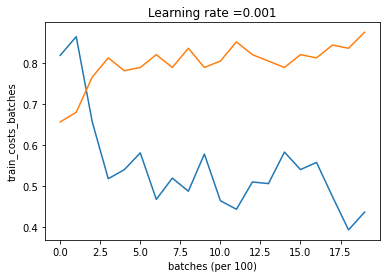

epoch,5
train loss,0.46618
train accuracy,0.84015
_runtime,18
_timestamp,1615558165
_step,9
val loss,0.46392
val accuracy,0.835


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▇▇▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▄▂▁
val accuracy,▁▅▅▇█


wandb: Agent Starting Run: fbgg5l8a with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.7854375502709812
val accuracy for epoch  1 =  0.7043333333333334
train cost for epoch  1 =  1.0231500345934403
train accuracy for epoch  1 =  0.5936481481481481

val cost for epoch  2 =  0.6008092778714696
val accuracy for epoch  2 =  0.791
train cost for epoch  2 =  0.6588939225229927
train accuracy for epoch  2 =  0.7672037037037037

val cost for epoch  3 =  0.5327376793813733
val accuracy for epoch  3 =  0.8135
train cost for epoch  3 =  0.5555419811086351
train accuracy for epoch  3 =  0.8081481481481482

val cost for epoch  4 =  0.49916569216518936
val accuracy for epoch  4 =  0.8266666666666667
train cost for epoch  4 =  0.5080670410684281
train accuracy for epoch  4 =  0.827037037037037

val cost for epoch  5 =  0.4854753016554768
val accuracy for epoch  5 =  0.8231666666666667
train cost for epoch  5 =  0.47993059415704853
train accuracy for epoch  5 =  0.8340185185185185



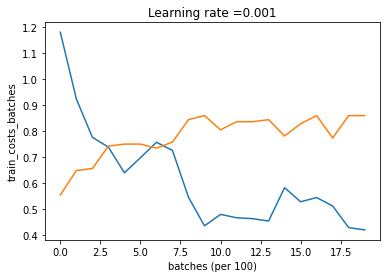

epoch,5
train loss,0.47993
train accuracy,0.83402
_runtime,20
_timestamp,1615558190
_step,9
val loss,0.48548
val accuracy,0.82317


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▂▃▄▅▆▆██
_timestamp,▁▁▂▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▁▁
val accuracy,▁▆▇██


wandb: Agent Starting Run: ax6lrpka with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.120685133716604
val accuracy for epoch  1 =  0.5265
train cost for epoch  1 =  1.3991075436243328
train accuracy for epoch  1 =  0.39261111111111113

val cost for epoch  2 =  1.0218764859113934
val accuracy for epoch  2 =  0.575
train cost for epoch  2 =  1.06856318035159
train accuracy for epoch  2 =  0.5493703703703704

val cost for epoch  3 =  0.9621103115373236
val accuracy for epoch  3 =  0.5986666666666667
train cost for epoch  3 =  0.9784056215519125
train accuracy for epoch  3 =  0.5947962962962963

val cost for epoch  4 =  0.8793791511940285
val accuracy for epoch  4 =  0.6471666666666667
train cost for epoch  4 =  0.9012210612749479
train accuracy for epoch  4 =  0.6457592592592593

val cost for epoch  5 =  0.8275210709708168
val accuracy for epoch  5 =  0.677
train cost for epoch  5 =  0.8459262140203113
train accuracy for epoch  5 =  0.6742962962962963



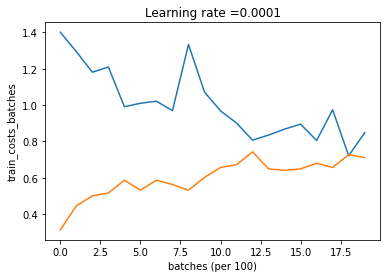

epoch,5
train loss,0.84593
train accuracy,0.6743
_runtime,19
_timestamp,1615558214
_step,9
val loss,0.82752
val accuracy,0.677


epoch,▁▃▅▆█
train loss,█▄▃▂▁
train accuracy,▁▅▆▇█
_runtime,▁▁▃▃▄▅▆▇██
_timestamp,▁▁▃▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▄▂▁
val accuracy,▁▃▄▇█


wandb: Agent Starting Run: tyvfesuy with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.4803637204313316
val accuracy for epoch  1 =  0.3348333333333333
train cost for epoch  1 =  1.8888346579895408
train accuracy for epoch  1 =  0.2363148148148148

val cost for epoch  2 =  1.3157016383430982
val accuracy for epoch  2 =  0.4111666666666667
train cost for epoch  2 =  1.3703596203505857
train accuracy for epoch  2 =  0.38187037037037036

val cost for epoch  3 =  1.2589218420705133
val accuracy for epoch  3 =  0.4186666666666667
train cost for epoch  3 =  1.2875834261719215
train accuracy for epoch  3 =  0.4140740740740741

val cost for epoch  4 =  1.2396250760162524
val accuracy for epoch  4 =  0.4221666666666667
train cost for epoch  4 =  1.2559445791381318
train accuracy for epoch  4 =  0.4224259259259259

val cost for epoch  5 =  1.2169754357154705
val accuracy for epoch  5 =  0.4325
train cost for epoch  5 =  1.2315191883856438
train accuracy for epoch  5 =  0.4328148148148148



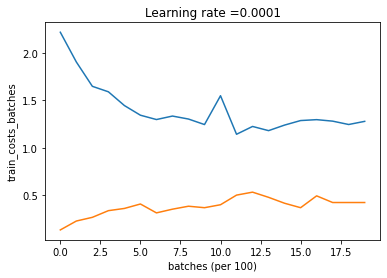

epoch,5
train loss,1.23152
train accuracy,0.43281
_runtime,22
_timestamp,1615558243
_step,9
val loss,1.21698
val accuracy,0.4325


epoch,▁▃▅▆█
train loss,█▂▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▂▁
val accuracy,▁▆▇▇█


wandb: Agent Starting Run: gn9fot21 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6749179755394958
val accuracy for epoch  1 =  0.7523333333333333
train cost for epoch  1 =  0.9708488641323906
train accuracy for epoch  1 =  0.608037037037037

val cost for epoch  2 =  0.55737906308991
val accuracy for epoch  2 =  0.8061666666666667
train cost for epoch  2 =  0.6159987024454071
train accuracy for epoch  2 =  0.7861481481481482

val cost for epoch  3 =  0.5615251280198919
val accuracy for epoch  3 =  0.8065
train cost for epoch  3 =  0.5502452361840804
train accuracy for epoch  3 =  0.815962962962963

val cost for epoch  4 =  0.5044174595962243
val accuracy for epoch  4 =  0.8248333333333333
train cost for epoch  4 =  0.5173673745255739
train accuracy for epoch  4 =  0.8300555555555555

val cost for epoch  5 =  0.4937758347805202
val accuracy for epoch  5 =  0.8348333333333333
train cost for epoch  5 =  0.5029239671043757
train accuracy for epoch  5 =  0.8362592592592593



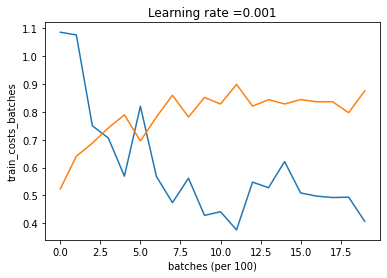

epoch,5
train loss,0.50292
train accuracy,0.83626
_runtime,20
_timestamp,1615558268
_step,9
val loss,0.49378
val accuracy,0.83483


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▂▃▃▄▅▆▆██
_timestamp,▁▂▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▃▄▁▁
val accuracy,▁▆▆▇█


wandb: Agent Starting Run: 3qje3nm7 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 64-32-32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  1.1240015807988952
val accuracy for epoch  1 =  0.466
train cost for epoch  1 =  1.3426232261664666
train accuracy for epoch  1 =  0.4029259259259259

val cost for epoch  2 =  1.0281535877631491
val accuracy for epoch  2 =  0.5711666666666667
train cost for epoch  2 =  1.0681534391110448
train accuracy for epoch  2 =  0.5406851851851852

val cost for epoch  3 =  0.8909766040032547
val accuracy for epoch  3 =  0.6348333333333334
train cost for epoch  3 =  0.9539345495916423
train accuracy for epoch  3 =  0.6080925925925926

val cost for epoch  4 =  0.8194214806453903
val accuracy for epoch  4 =  0.691
train cost for epoch  4 =  0.8368488752060311
train accuracy for epoch  4 =  0.6819074074074074

val cost for epoch  5 =  0.7367386218033967
val accuracy for epoch  5 =  0.7278333333333333
train cost for epoch  5 =  0.7608772030508436
train accuracy for epoch  5 =  0.7222777777777778



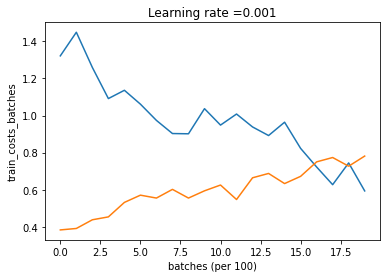

epoch,5
train loss,0.76088
train accuracy,0.72228
_runtime,20
_timestamp,1615558292
_step,9
val loss,0.73674
val accuracy,0.72783


epoch,▁▃▅▆█
train loss,█▅▃▂▁
train accuracy,▁▄▅▇█
_runtime,▁▁▂▃▄▅▆▆██
_timestamp,▁▁▂▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▄▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: frz7w21m with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6210277895746755
val accuracy for epoch  1 =  0.7705
train cost for epoch  1 =  0.887395057063657
train accuracy for epoch  1 =  0.6627222222222222

val cost for epoch  2 =  0.5097428066712361
val accuracy for epoch  2 =  0.815
train cost for epoch  2 =  0.552496313735455
train accuracy for epoch  2 =  0.8045555555555556

val cost for epoch  3 =  0.4601454090181645
val accuracy for epoch  3 =  0.8331666666666667
train cost for epoch  3 =  0.4776080075473132
train accuracy for epoch  3 =  0.8338518518518518

val cost for epoch  4 =  0.4344396446354772
val accuracy for epoch  4 =  0.8433333333333334
train cost for epoch  4 =  0.4319741127137057
train accuracy for epoch  4 =  0.8482777777777778

val cost for epoch  5 =  0.41731674514057954
val accuracy for epoch  5 =  0.8535
train cost for epoch  5 =  0.407077347934463
train accuracy for epoch  5 =  0.8574814814814815



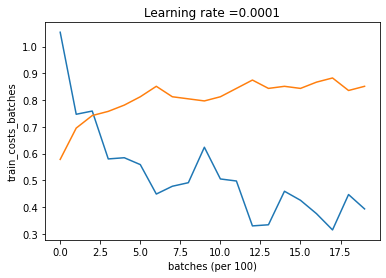

epoch,5
train loss,0.40708
train accuracy,0.85748
_runtime,29
_timestamp,1615558326
_step,9
val loss,0.41732
val accuracy,0.8535


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▂▂▁
val accuracy,▁▅▆▇█


wandb: Agent Starting Run: gfr5is11 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.9912280078743522
val accuracy for epoch  1 =  0.6041666666666666
train cost for epoch  1 =  1.372226286276107
train accuracy for epoch  1 =  0.4568333333333333

val cost for epoch  2 =  0.8704515998621227
val accuracy for epoch  2 =  0.6553333333333333
train cost for epoch  2 =  0.9153896785275971
train accuracy for epoch  2 =  0.6369259259259259

val cost for epoch  3 =  0.7918668045022195
val accuracy for epoch  3 =  0.6966666666666667
train cost for epoch  3 =  0.8248301991067143
train accuracy for epoch  3 =  0.6822962962962963

val cost for epoch  4 =  0.7438517499675824
val accuracy for epoch  4 =  0.7205
train cost for epoch  4 =  0.7600938236269449
train accuracy for epoch  4 =  0.7207777777777777

val cost for epoch  5 =  0.7055151973005113
val accuracy for epoch  5 =  0.7396666666666667
train cost for epoch  5 =  0.7190073204322353
train accuracy for epoch  5 =  0.7395



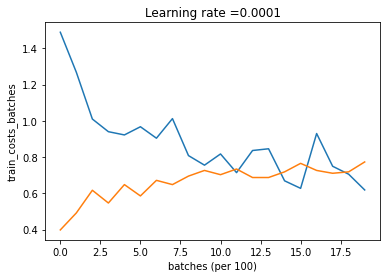

epoch,5
train loss,0.71901
train accuracy,0.7395
_runtime,31
_timestamp,1615558362
_step,9
val loss,0.70552
val accuracy,0.73967


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▅▇██
_runtime,▁▁▃▃▄▅▆▆▇█
_timestamp,▁▁▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▅▃▂▁
val accuracy,▁▄▆▇█


wandb: Agent Starting Run: gkeasovf with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.513501902185551
val accuracy for epoch  1 =  0.8116666666666666
train cost for epoch  1 =  0.670742874568252
train accuracy for epoch  1 =  0.7539074074074074

val cost for epoch  2 =  0.49296396241286816
val accuracy for epoch  2 =  0.8198333333333333
train cost for epoch  2 =  0.5099991088649365
train accuracy for epoch  2 =  0.8248148148148148

val cost for epoch  3 =  0.4656507603569133
val accuracy for epoch  3 =  0.8271666666666667
train cost for epoch  3 =  0.48095903789376504
train accuracy for epoch  3 =  0.8338703703703704

val cost for epoch  4 =  0.46114289182576906
val accuracy for epoch  4 =  0.8391666666666666
train cost for epoch  4 =  0.4566305009033993
train accuracy for epoch  4 =  0.8447777777777777

val cost for epoch  5 =  0.4326861832395289
val accuracy for epoch  5 =  0.8451666666666666
train cost for epoch  5 =  0.4475416392454977
train accuracy for epoch  5 =  0.8478333333333333



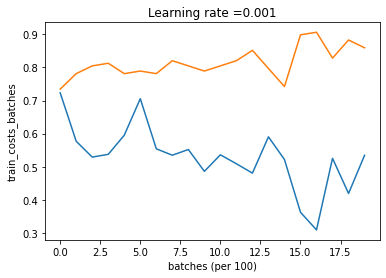

epoch,5
train loss,0.44754
train accuracy,0.84783
_runtime,29
_timestamp,1615558397
_step,9
val loss,0.43269
val accuracy,0.84517


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▅▅▆▆██
_timestamp,▁▁▃▃▅▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▆▄▃▁
val accuracy,▁▃▄▇█


wandb: Agent Starting Run: m49ttyhc with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.8
wandb: 	epochs: 5
wandb: 	hidden_layers_config: 128-128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5757329212307277
val accuracy for epoch  1 =  0.792
train cost for epoch  1 =  0.8145180846796984
train accuracy for epoch  1 =  0.6907222222222222

val cost for epoch  2 =  0.47118683402098016
val accuracy for epoch  2 =  0.8281666666666667
train cost for epoch  2 =  0.5087330006076048
train accuracy for epoch  2 =  0.8211666666666667

val cost for epoch  3 =  0.4740809801876856
val accuracy for epoch  3 =  0.8255
train cost for epoch  3 =  0.43966721642740797
train accuracy for epoch  3 =  0.8458333333333333

val cost for epoch  4 =  0.41401548853004283
val accuracy for epoch  4 =  0.8515
train cost for epoch  4 =  0.40563034160251177
train accuracy for epoch  4 =  0.8574444444444445

val cost for epoch  5 =  0.39203147099911156
val accuracy for epoch  5 =  0.8606666666666667
train cost for epoch  5 =  0.3811572016244706
train accuracy for epoch  5 =  0.8665925925925926



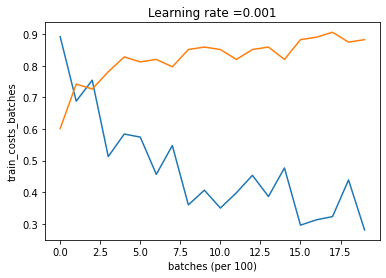

epoch,5
train loss,0.38116
train accuracy,0.86659
_runtime,27
_timestamp,1615558429
_step,9
val loss,0.39203
val accuracy,0.86067


epoch,▁▃▅▆█
train loss,█▃▂▁▁
train accuracy,▁▆▇██
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val loss,█▄▄▂▁
val accuracy,▁▅▄▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [11]:
wandb.agent(sweep_id, sp_train)